<h2 style="text-align: center;">Imputer choice based on the C-index score for Cox-model</h2>

 - This notebook helps to choose the best imputer for each type of data: numerical, categorical, binomial.
 - Also it helps to choose the best scaling method for numerical values to prepare data for the survival model analysis. 



## Results:
Feature importancy plots for each parameters choice  
The plot of C-index value for each imputer type for training (training + test) and test dataset. 

## Steps: 
1) Full fill the parameters or parameters list what you want to check for the model C-index influence. 
2) Check plots of Feature importancy

In [1]:
#import all modules to the project to use functions

import sys
from pathlib import Path

# This should point to the project root where 'modules' directory is located
project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# importing modules
from modules import *

In [2]:
import numpy as np
import pandas as pd
import re
import os
from datetime import datetime
import csv

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer, Normalizer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


Set_up_option
color_style

<function modules.color_style.color_style()>

# Choose information about dataset

### 1) Choose Imputer type for exploration:
* 'num' -  numerical, 
* 'cat' - categorical (binomial included), 
* 'scale' - scaler type for numerical

In [3]:
#1) Choose Imputer type for exploration
imputers_type = 'scale' #'num' 'cat' 'scale' 

### 2) Next choose different parameters of data, data preprocessing and cox model in lists to develope imputer based on the C-value for cox model

In [4]:
#type of data train or test (only if train was done before and the model was saved)
data_name_list = ['training_df', 'test_df']
data_frame_type_list = ['training','test']

#True/False - on/off categories combination with small statistic (< 6%) -> Create list of combined categories per each feature
combine_categories_list = [True] 
#combine_categories_list = [False,True]
 
# True/ False - on/off Significant feature clean up. This procedure drop less significant features during Cox model development
clean_feature_list = [True] 
#clean_feature_list = [False,True]

# Parameter of preprocess_data function - the maximum percent of high missing values to drop features with bigger percent of missing values 
threshold_feature_drop_list = [25] 
#threshold_feature_drop_list = [22,25,27,30]

#parameter of cox model
penalize_list=[0.001] 
#penalize_list=[0.0001,0.001,0.01,0.1]
l1_ratio_list=[0.9] 
#l1_ratio_list=[0.7,0.8,0.9]

#ECOG binomial 0/1: bin category 0,1 - 0; 2,3,4 - 1
#ECOG categorical:  0/1/2/3/4
ecog_type = 'bin' #'cat'



### 3) Next we will variate imputers for one category data and fix the other categories imputer

1) Fix Default imputers - this you can modify
2) Specify the name of the plot, shows C-index value for each imputer variation for the category.

In [5]:
# Default Imputers
cat_imputer = SimpleImputer(strategy='most_frequent')
scaler = QuantileTransformer() 
num_imputer = KNNImputer(n_neighbors=10)


In [6]:
# Create the name to store the plot of C-index scores imputer types comparison, 
# when two imputer categories are fixed. 

additional_name_plot = name_imputer_comparison_for_plot_create(imputers_type, cat_imputer, num_imputer, scaler)

### 3) List of most frequent imputers for each category.
You can add or completly  modify the imputers list for specific one what you want to compare. 

 ### a) Scaler list

In [7]:
# List of 7 different scalers
scalers_list = [
    StandardScaler(),          # Standardizes features by removing the mean and scaling to unit variance
    MinMaxScaler(),            # Scales features to a given range, typically between 0 and 1
    RobustScaler(),            # Scales features using statistics that are robust to outliers
    QuantileTransformer(),     # Maps data to a uniform or Gaussian distribution
    Normalizer(),              # Normalizes samples individually to unit norm
    MaxAbsScaler(),            # Scales each feature by its maximum absolute value
    PowerTransformer(),        # Applies a power transform to make data more Gaussian-like
]

 ### b) Numerical imputers list

In [8]:
# Define imputers for numerical data
simple_imputer_mean = SimpleImputer(strategy='mean')  # Impute using the mean of each column
simple_imputer_median = SimpleImputer(strategy='median')  # Impute using the median of each column
simple_imputer_constant = SimpleImputer(strategy='constant', fill_value=0)  # Impute using a constant value (e.g., 0)
knn_imputer_5 = KNNImputer(n_neighbors=5)  # Impute using the k-nearest neighbors
knn_imputer_3 = KNNImputer(n_neighbors=3)  # Impute using the k-nearest neighbors
knn_imputer_10 = KNNImputer(n_neighbors=10)  # Impute using the k-nearest neighbors
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)  # Impute using iterative imputer (model-based imputation)

# List of 7 different type of numerical imputers
numerical_imputers_list = [
    simple_imputer_mean,
    simple_imputer_median,
    simple_imputer_constant,
    knn_imputer_3,
    knn_imputer_5,
    knn_imputer_10,
    iterative_imputer
]

 ### c) Categorical imputers list

In [9]:
# categorical imputers
simple_imputer_most_frequent = SimpleImputer(strategy='most_frequent')
simple_imputer_constant = SimpleImputer(strategy='constant', fill_value=0)
knn_imputer_5 = KNNImputer(n_neighbors=5)
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)

# List of categorical imputers
categorical_imputers_list_1 = [
    simple_imputer_most_frequent,
    SimpleImputer(strategy='median'),
    SimpleImputer(strategy='constant', fill_value=1),
    SimpleImputer(strategy='constant', fill_value=2),
    simple_imputer_constant,
    knn_imputer_5,
    knn_imputer_10,
    IterativeImputer(max_iter=10, random_state=1),
    IterativeImputer(max_iter=15, random_state=0),
    IterativeImputer(max_iter=5, random_state=0)
]


## Main Analysis

* Below is the loop that helps to go throught the different parameters of data preprocessing and cox model to find the best imputer in the category. Best imputer can be found by comparison of C-index for train and test data on the plot. 

* The loop calculates the C-index value and builts the feature importancy plot for each specific set of parametes.
Result you can find in the section Result below.

In [10]:
# Preparing imputers_list for analysis
imputers_list=[]

if imputers_type == 'num':
     imputers_list = numerical_imputers_list
elif imputers_type == 'cat':
     imputers_list = categorical_imputers_list_1
elif imputers_type=='scale':
     imputers_list = scalers_list

In [11]:
imputer_choice_directory = create_directory_main('imputer_choice')

Directory ../intermediate_report exist
Directory '../intermediate_report/24-03-18_imputer_choice' created successfully.
Directory '../intermediate_report/24-03-18_imputer_choice/figures' created successfully.


/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Directory ../intermediate_report exist
Directory '../intermediate_report/24-03-18_training_df' created successfully.
Directory '../intermediate_report/24-03-18_training_df/figures' created successfully.
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2_lightlam', 'l1_supperythnr', 'l2_supperythnr', 'l1_TTNT', 'l2_TTNT']
dx_weight         float64
l1_weight         float64
l2_weight         float64
dx_height         float64
l1_height         float64
l2_height         float64
dx_kofscore       float64
l1_kofscore       float64
l2_kofscore       float64
dx_protg          float64
l1_protg          float64
l2_protg          float64
dx_lightrat        object
l1_lightrat        object
l2_lightrat        object


/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

Wrong data in column dx_BMI:
Series([], Name: dx_BMI, dtype: float64)
Wrong data in column l1_BMI:
389     359.168242
593     254.687500
1129    289.062500
1403    228.373702
1779    227.272727
Name: l1_BMI, dtype: float64
Wrong data in column l2_BMI:
550     164.359862
1129    289.062500
Name: l2_BMI, dtype: float64
 
Total number of rows with wrong data: 
(7, 393)
 
Wrong data: 
      dx_weight  l1_weight  l2_weight  dx_height  l1_height  l2_height
389        69.0      171.0       68.0      170.0       69.0      171.0
593       163.0      163.0       80.0      180.0       80.0      163.0
1129       90.0      185.0      185.0      185.0       80.0       80.0
1403       85.0      165.0       85.0      165.0       85.0      165.0
1779       88.0      176.0       90.0      176.0       88.0      176.0
550        81.0       81.0       76.0      169.0      169.0       68.0
1129       90.0      185.0      185.0      185.0       80.0       80.0
 
Corrected data: 
      dx_weight  l1_weight  l

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


                  covariate                                  feature_name
0            bin__l1_drug_6                                   Drug 6 (l1)
1            bin__l1_drug_1                                   Drug 1 (l1)
2            bin__l1_drug_7                                   Drug 7 (l1)
3         bin__dx_crabkritr                        Renal dysfunction (dx)
4           bin__l2_ecogbin                                     ECOG (l2)
5         bin__l2_suppdurch                       Supportive therapy (l2)
6         bin__l1_crabkritc                           Hypercalcaemia (l1)
7            bin__l1_drug_2                                   Drug 2 (l1)
8         bin__l2_crabkrita                                  Anaemia (l2)
9             num__l2_protg                            M-Protein g/l (l2)
10       num__l2_BMI_change                               BMI change (l2)
11              num__dx_BMI                                           BMI
12          cat__l2_fit_2.0           

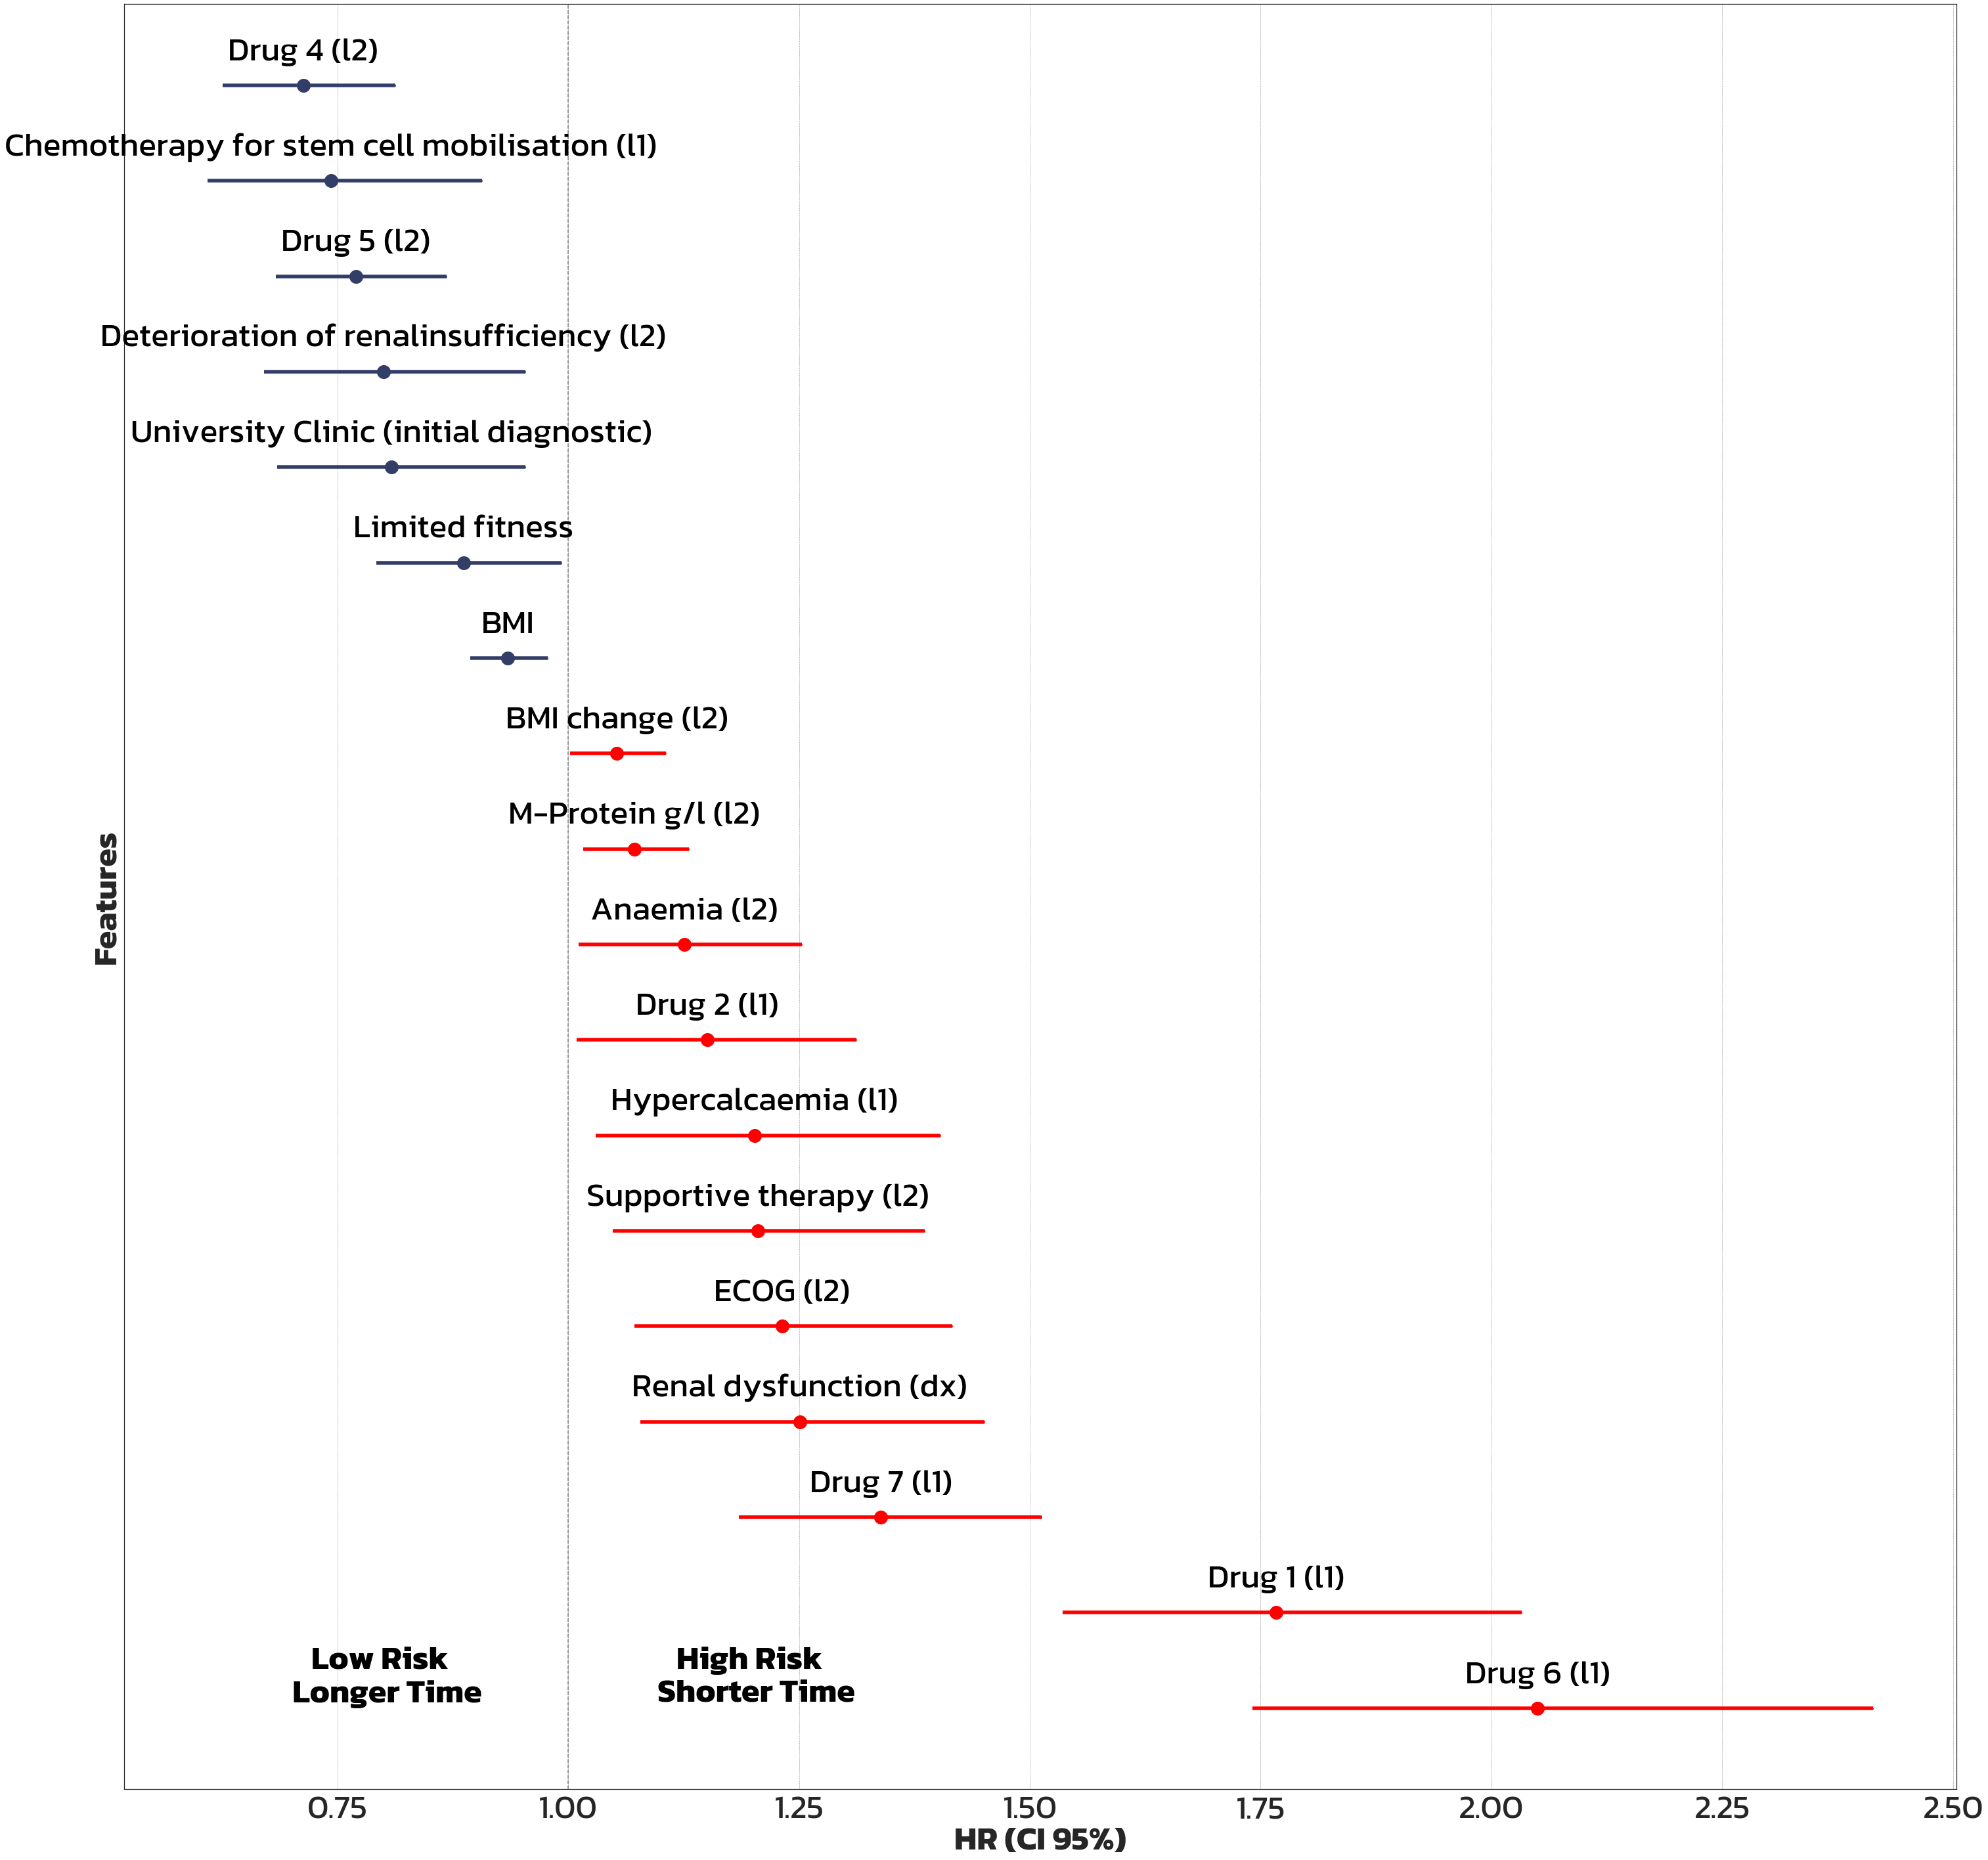

0.6127421370596045 0.6099884976438722
C-index with Lasso less significant features clean-up method:
train: 0.6127421370596045 test: 0.6099884976438722
C-index without Lasso less significant features clean-up method:
train: 0.6160933074794399 test: 0.612207339245297
['training_df', 'training', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'StandardScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 0.6127421370596045, 0.6099884976438722, 0.6160933074794399, 0.612207339245297]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' created.
Directory ../intermediate_report exist
Directory '../intermediate_report/24-03-18_test_df' created successfully.
Directory '../intermediate_report/24-03-18_test_df/figures' created successfully.
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows


 
Data with Nan:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Check if data is in good range for height and weight: 
 
Height <110:
Emp

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/feature_dropping.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/data_preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['event'] = 1
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119:

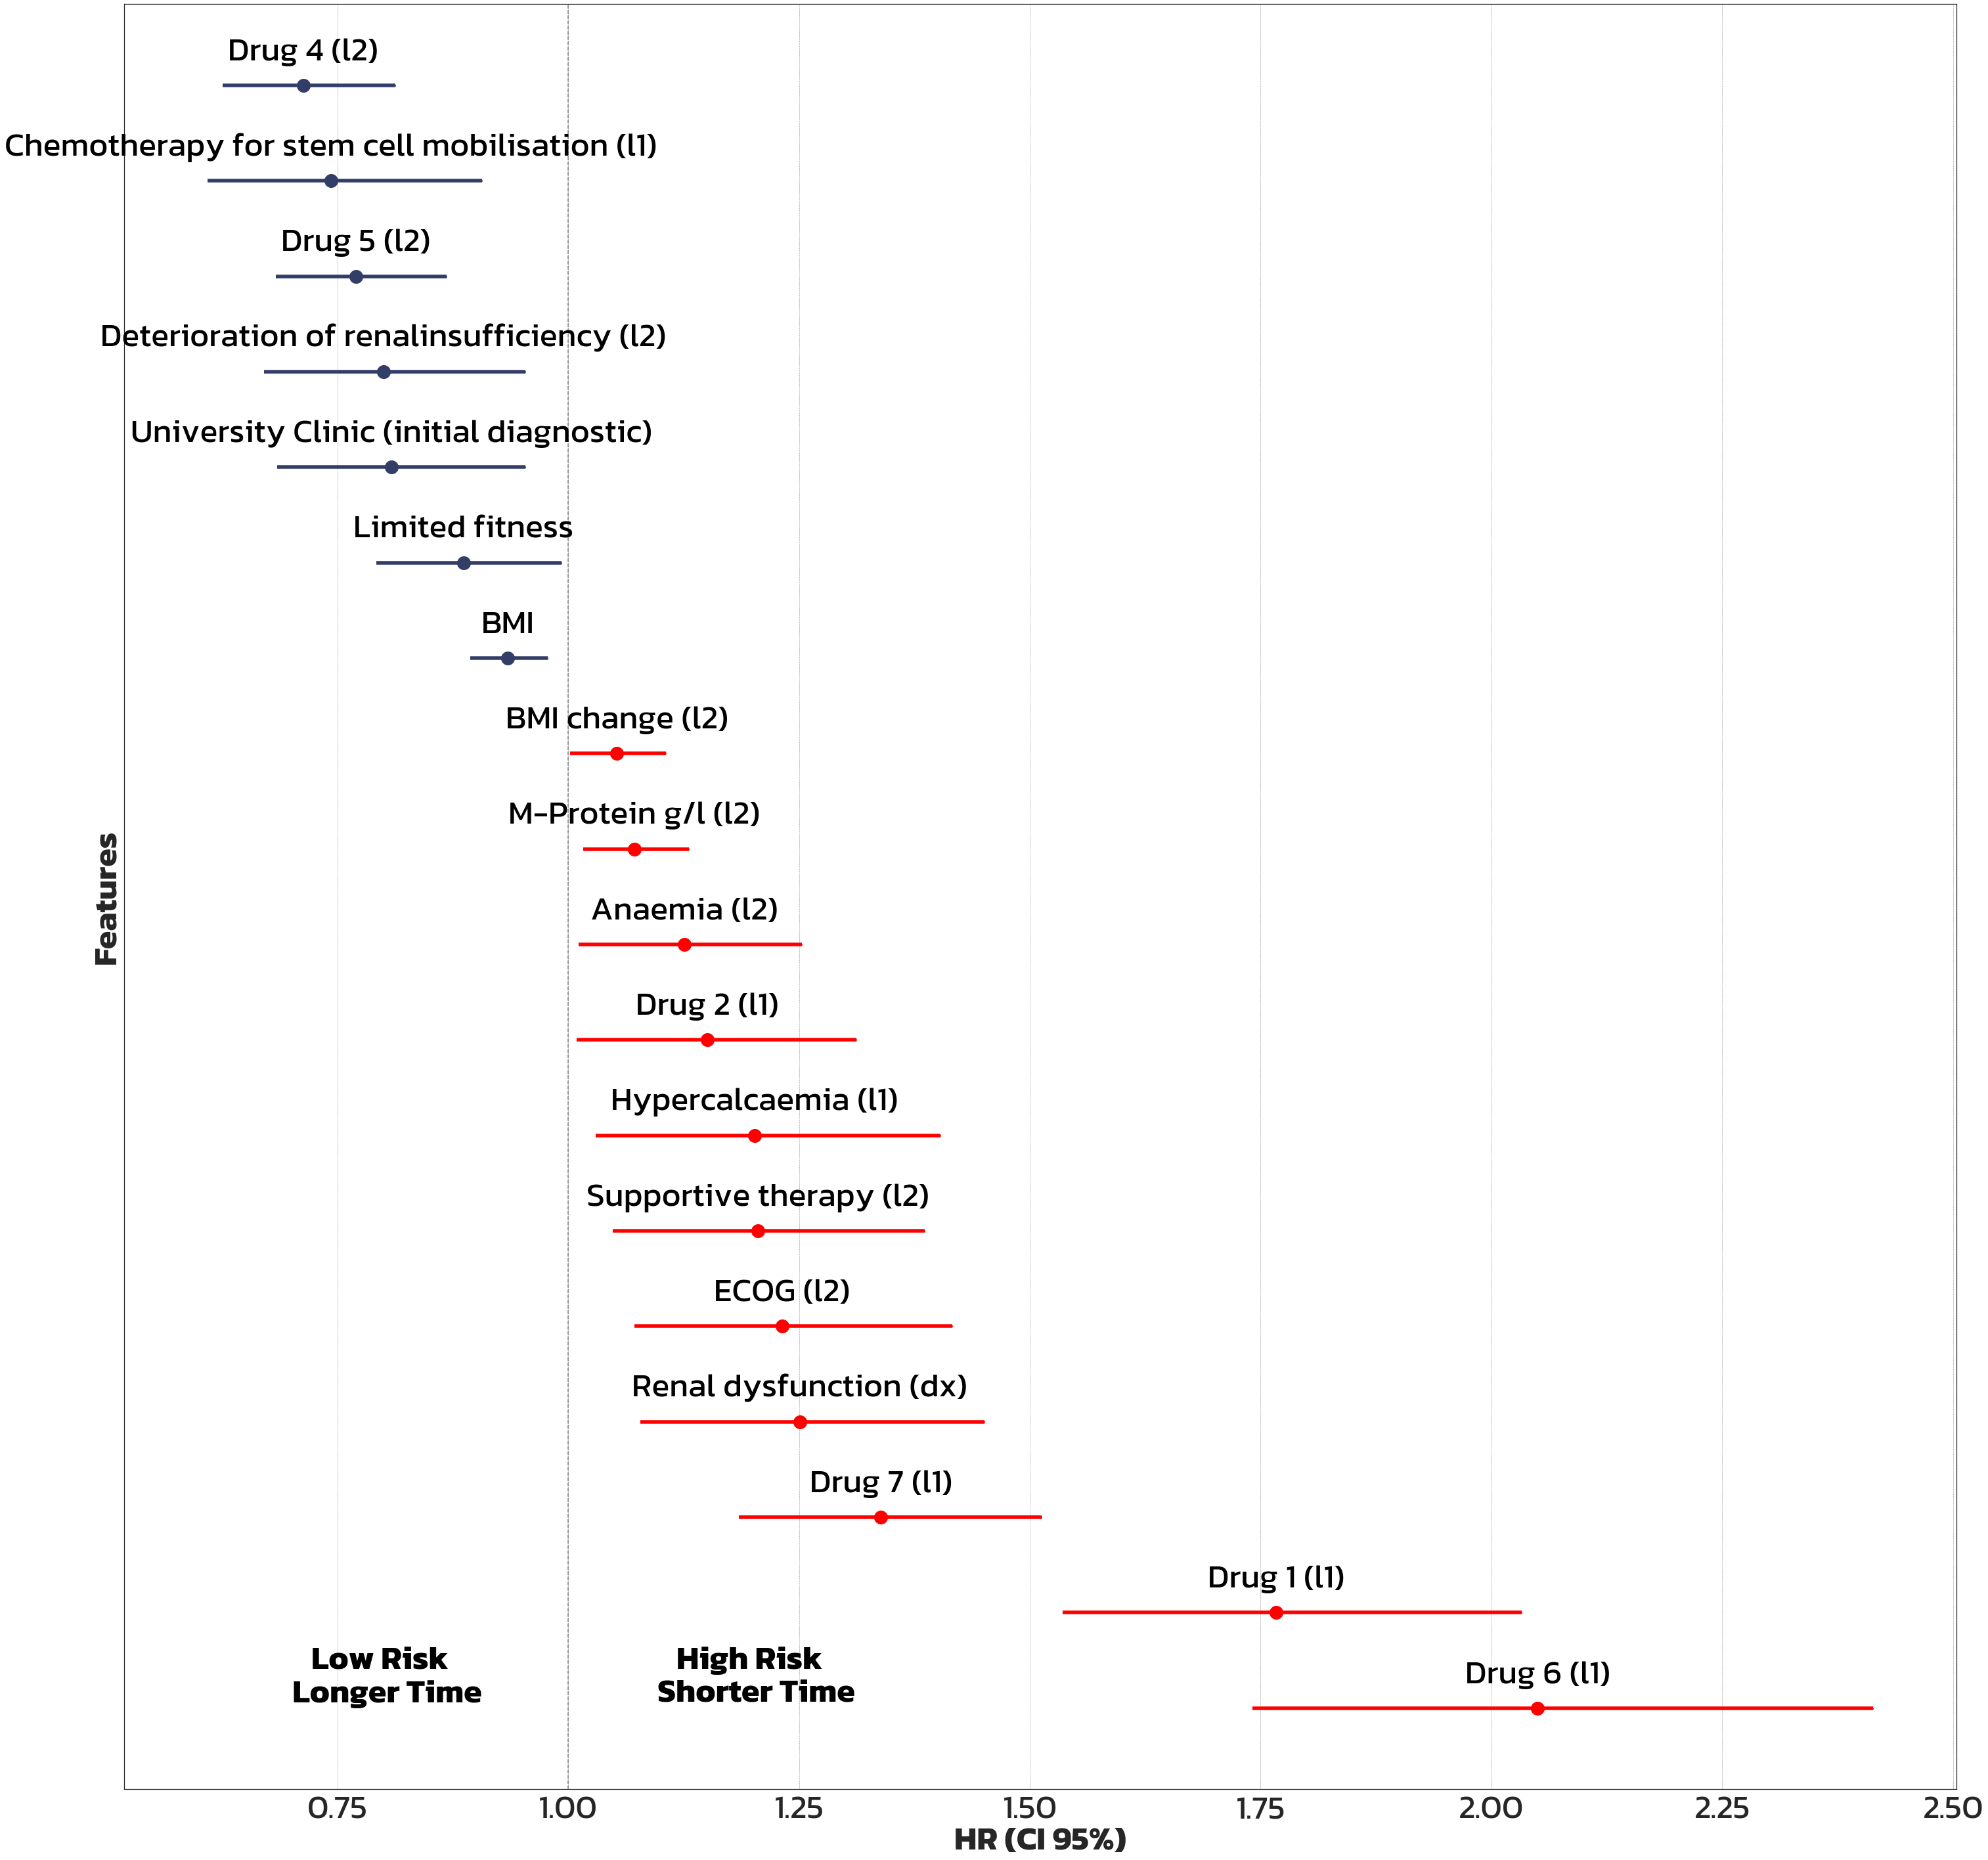

C-index with Lasso less significant features clean-up method:
train: not related test: 0.6097154691157932
C-index without Lasso less significant features clean-up method:
train: not related test: 0.6078532488581111
['test_df', 'test', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'StandardScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 'not related', 0.6097154691157932, 'not related', 0.6078532488581111]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_training_df exist
Directory ../intermediate_report/24-03-18_training_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightra

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


After convertion: 
dx_weight         float64
l1_weight         float64
l2_weight         float64
dx_height         float64
l1_height         float64
l2_height         float64
dx_kofscore       float64
l1_kofscore       float64
l2_kofscore       float64
dx_protg          float64
l1_protg          float64
l2_protg          float64
dx_lightrat       float64
l1_lightrat       float64
l2_lightrat       float64
dx_lightkap       float64
l1_lightkap       float64
l2_lightkap       float64
dx_lightlam       float64
l1_lightlam       float64
l2_lightlam       float64
l1_supperythnr    float64
l2_supperythnr    float64
l1_TTNT           float64
l2_TTNT             int64
dtype: object
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

Wrong data in column dx_BMI:
Series([], Name: dx_BMI, dtype: float64)
Wrong data in column l1_BMI:
Series([], Name: l1_BMI, dtype: float64)
Wrong data in column l2_BMI:
Series([], Name: l2_BMI, dtype: float64)
 
Total number of rows with wrong data: 
(0, 393)
 
Wrong data: 
Empty DataFrame
Columns: [dx_weight, l1_weight, l2_weight, dx_height, l1_height, l2_height]
Index: []
 
BMI_change was added to the dataframe
Control output of used datatype: 
['dx_birthd', 'dx_iddat', 'l1_opdat', 'l2_opdat', 'l1_rtxstartdat', 'l2_rtxstartdat', 'l1_rtxendedat', 'l2_rtxendedat']
START: DDMMYY_type_correction 

1. calculate duration of rtx
2. calculate relative age when patient was diagnosed
dx_iddat_age column was added to dataframe
l1_opdat_age column was added to dataframe
l2_opdat_age column was added to dataframe
3. Drop data ddmmyy-type columns
END: DDMMYY_type_correction 



../intermediate_report/24-03-18_training_df/raw_unique_values_and_missing_count.csv was created
List_ordinary_values:
['d

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


                  covariate                                  feature_name
0        num__l2_BMI_change                               BMI change (l2)
1            bin__l1_drug_6                                   Drug 6 (l1)
2            bin__l1_drug_1                                   Drug 1 (l1)
3             num__l2_protg                            M-Protein g/l (l2)
4            bin__l1_drug_7                                   Drug 7 (l1)
5         bin__dx_crabkritr                        Renal dysfunction (dx)
6           bin__l2_ecogbin                                     ECOG (l2)
7         bin__l2_suppdurch                       Supportive therapy (l2)
8         bin__l1_crabkritc                           Hypercalcaemia (l1)
9            bin__l1_drug_2                                   Drug 2 (l1)
10        bin__l2_crabkrita                                  Anaemia (l2)
11          cat__l2_fit_2.0                               Limited fitness
12       cat__dx_einrid_1.0        Uni

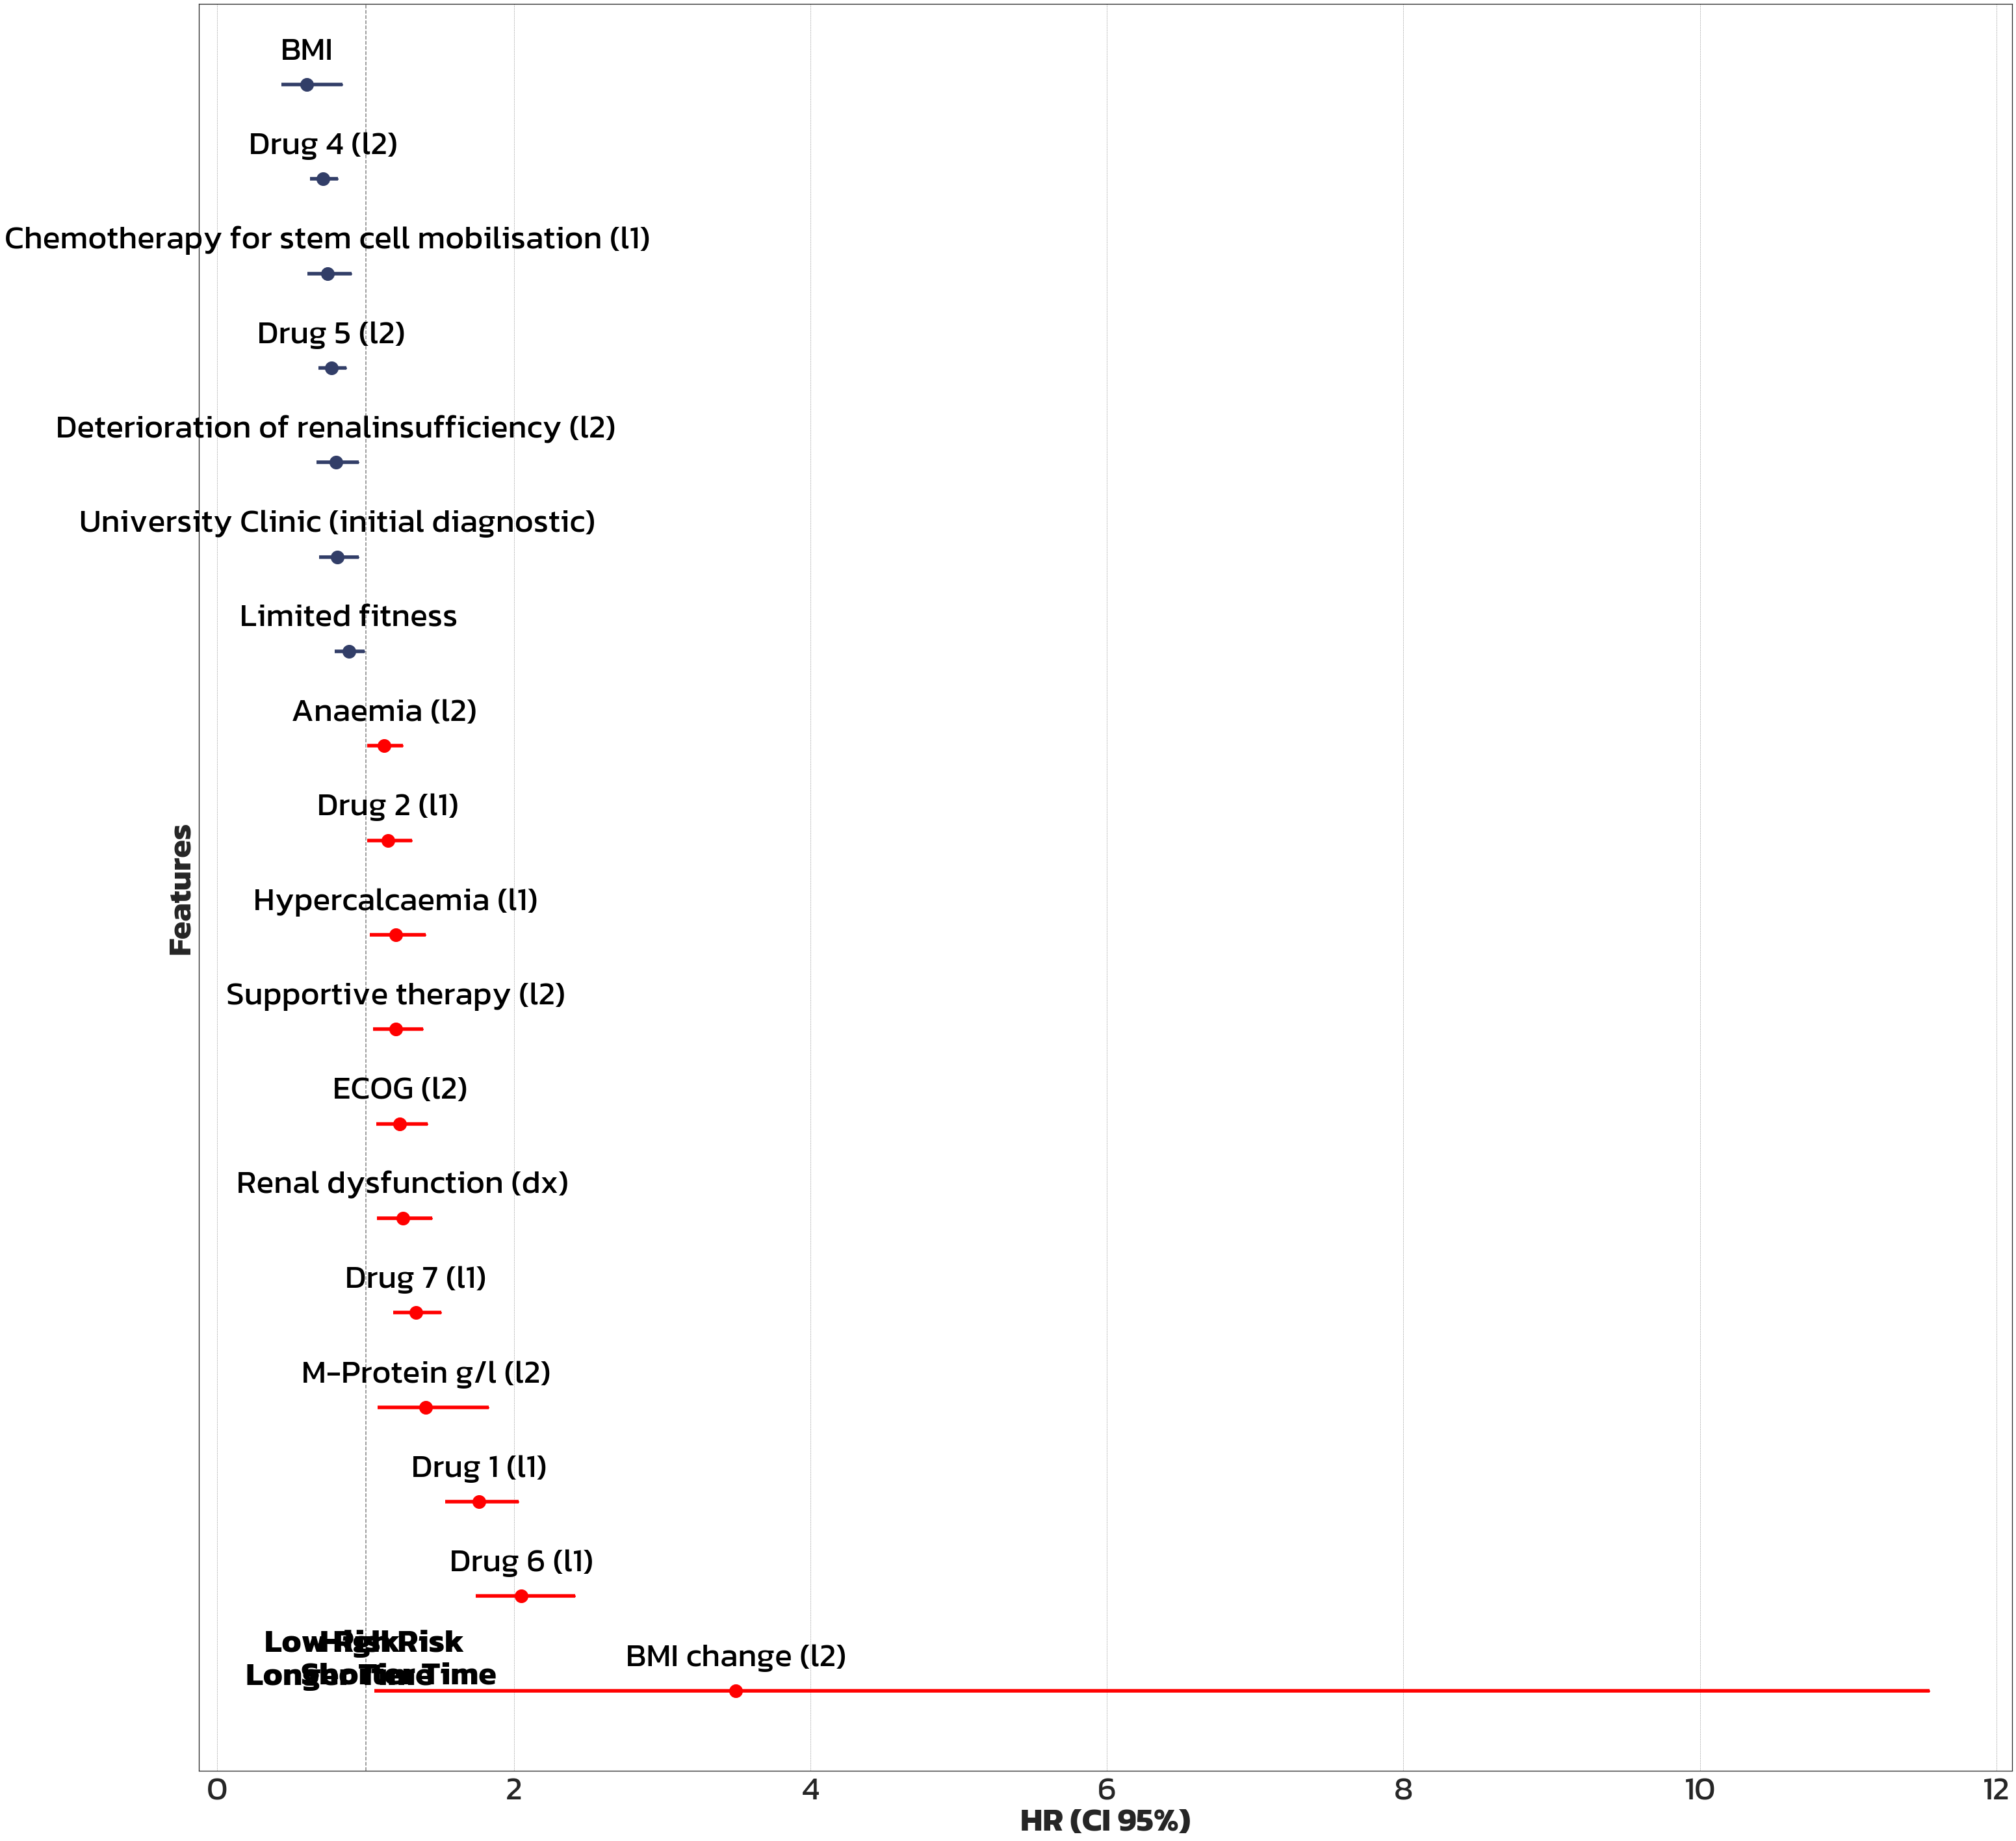

0.6127421370596045 0.6099884976438722
C-index with Lasso less significant features clean-up method:
train: 0.6127421370596045 test: 0.6099884976438722
C-index without Lasso less significant features clean-up method:
train: 0.6160933074794399 test: 0.612207339245297
['training_df', 'training', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'MinMaxScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 0.6127421370596045, 0.6099884976438722, 0.6160933074794399, 0.612207339245297]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_test_df exist
Directory ../intermediate_report/24-03-18_test_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows


 
Data with Nan:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Check if data is in good range for height and weight: 
 
Height <110:
Emp

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/feature_dropping.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/data_preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['event'] = 1
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119:

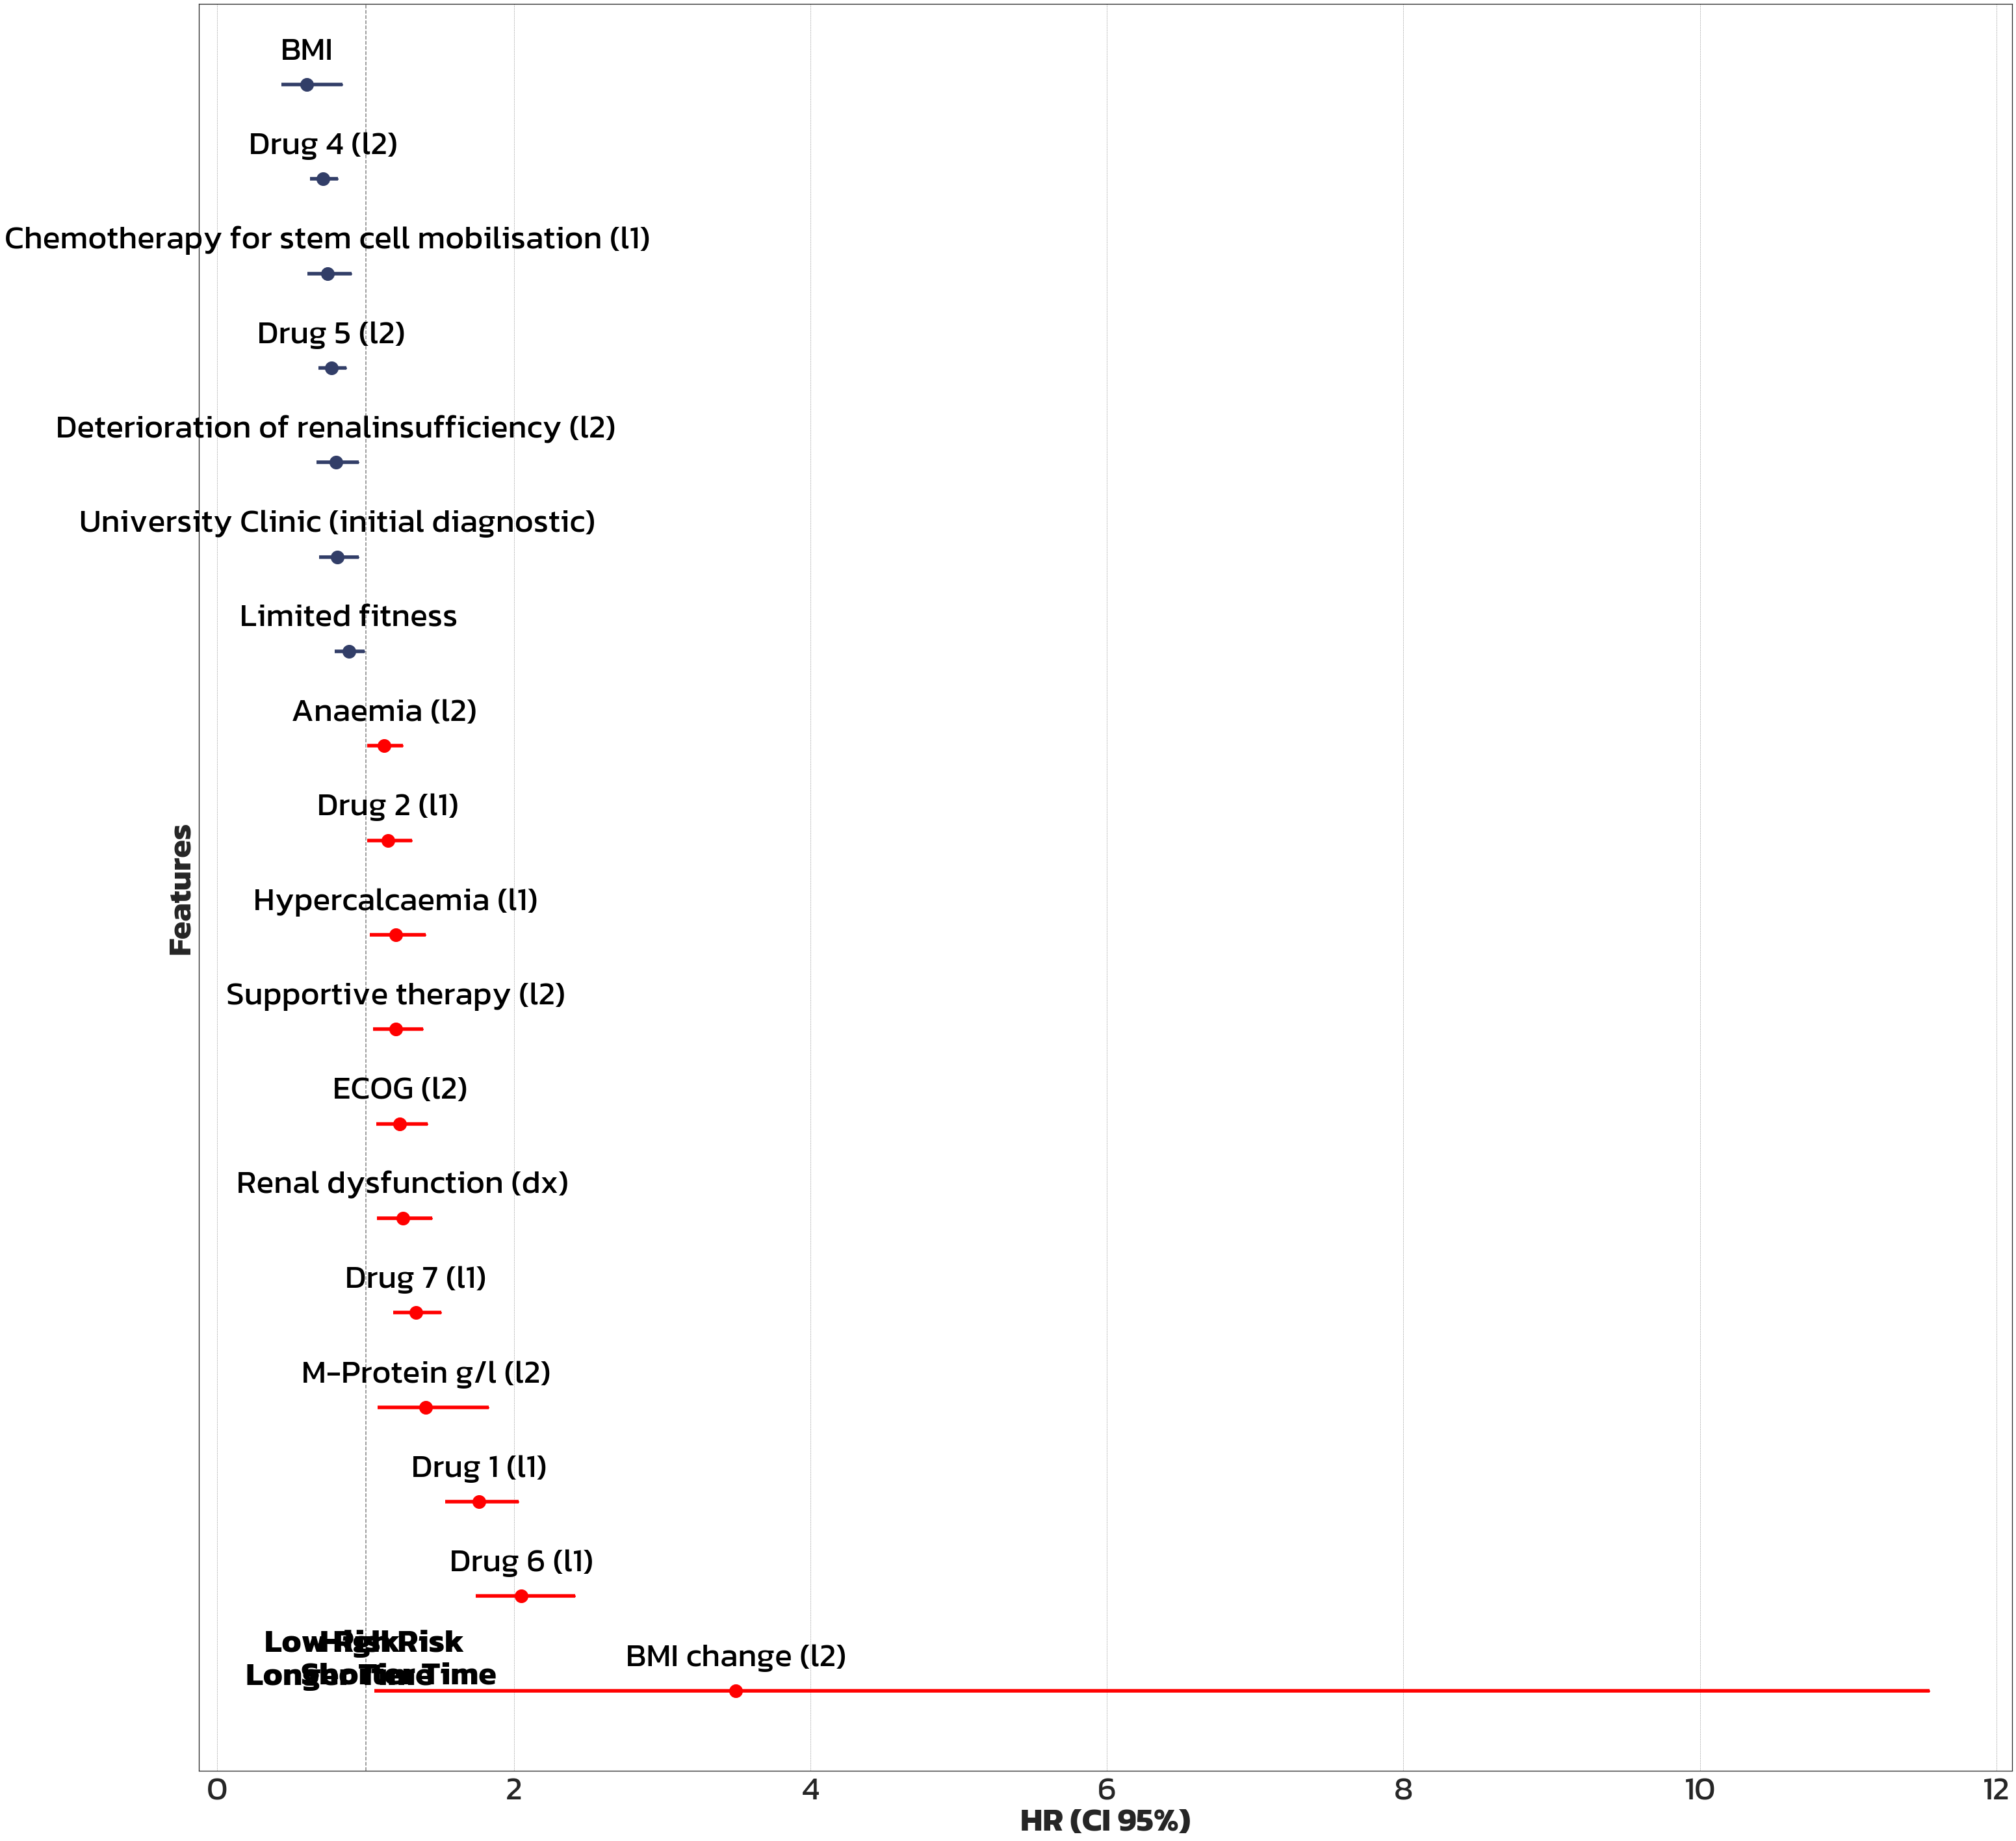

C-index with Lasso less significant features clean-up method:
train: not related test: 0.6097154691157932
C-index without Lasso less significant features clean-up method:
train: not related test: 0.6078532488581111
['test_df', 'test', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'MinMaxScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 'not related', 0.6097154691157932, 'not related', 0.6078532488581111]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_training_df exist
Directory ../intermediate_report/24-03-18_training_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat'

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


After convertion: 
dx_weight         float64
l1_weight         float64
l2_weight         float64
dx_height         float64
l1_height         float64
l2_height         float64
dx_kofscore       float64
l1_kofscore       float64
l2_kofscore       float64
dx_protg          float64
l1_protg          float64
l2_protg          float64
dx_lightrat       float64
l1_lightrat       float64
l2_lightrat       float64
dx_lightkap       float64
l1_lightkap       float64
l2_lightkap       float64
dx_lightlam       float64
l1_lightlam       float64
l2_lightlam       float64
l1_supperythnr    float64
l2_supperythnr    float64
l1_TTNT           float64
l2_TTNT             int64
dtype: object
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

Wrong data in column l1_BMI:
Series([], Name: l1_BMI, dtype: float64)
Wrong data in column l2_BMI:
Series([], Name: l2_BMI, dtype: float64)
 
Total number of rows with wrong data: 
(0, 393)
 
Wrong data: 
Empty DataFrame
Columns: [dx_weight, l1_weight, l2_weight, dx_height, l1_height, l2_height]
Index: []
 
BMI_change was added to the dataframe
Control output of used datatype: 
['dx_birthd', 'dx_iddat', 'l1_opdat', 'l2_opdat', 'l1_rtxstartdat', 'l2_rtxstartdat', 'l1_rtxendedat', 'l2_rtxendedat']
START: DDMMYY_type_correction 

1. calculate duration of rtx
2. calculate relative age when patient was diagnosed
dx_iddat_age column was added to dataframe
l1_opdat_age column was added to dataframe
l2_opdat_age column was added to dataframe
3. Drop data ddmmyy-type columns
END: DDMMYY_type_correction 



../intermediate_report/24-03-18_training_df/raw_unique_values_and_missing_count.csv was created
List_ordinary_values:
['dx_dusa', 'l1_dusa', 'dx_iss', 'l1_iss', 'l2_iss', 'dx_riss', 'l1_riss'

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


                  covariate                                  feature_name
0            bin__l1_drug_6                                   Drug 6 (l1)
1            bin__l1_drug_1                                   Drug 1 (l1)
2            bin__l1_drug_7                                   Drug 7 (l1)
3         bin__dx_crabkritr                        Renal dysfunction (dx)
4           bin__l2_ecogbin                                     ECOG (l2)
5         bin__l2_suppdurch                       Supportive therapy (l2)
6         bin__l1_crabkritc                           Hypercalcaemia (l1)
7            bin__l1_drug_2                                   Drug 2 (l1)
8         bin__l2_crabkrita                                  Anaemia (l2)
9             num__l2_protg                            M-Protein g/l (l2)
10       num__l2_BMI_change                               BMI change (l2)
11              num__dx_BMI                                           BMI
12          cat__l2_fit_2.0           

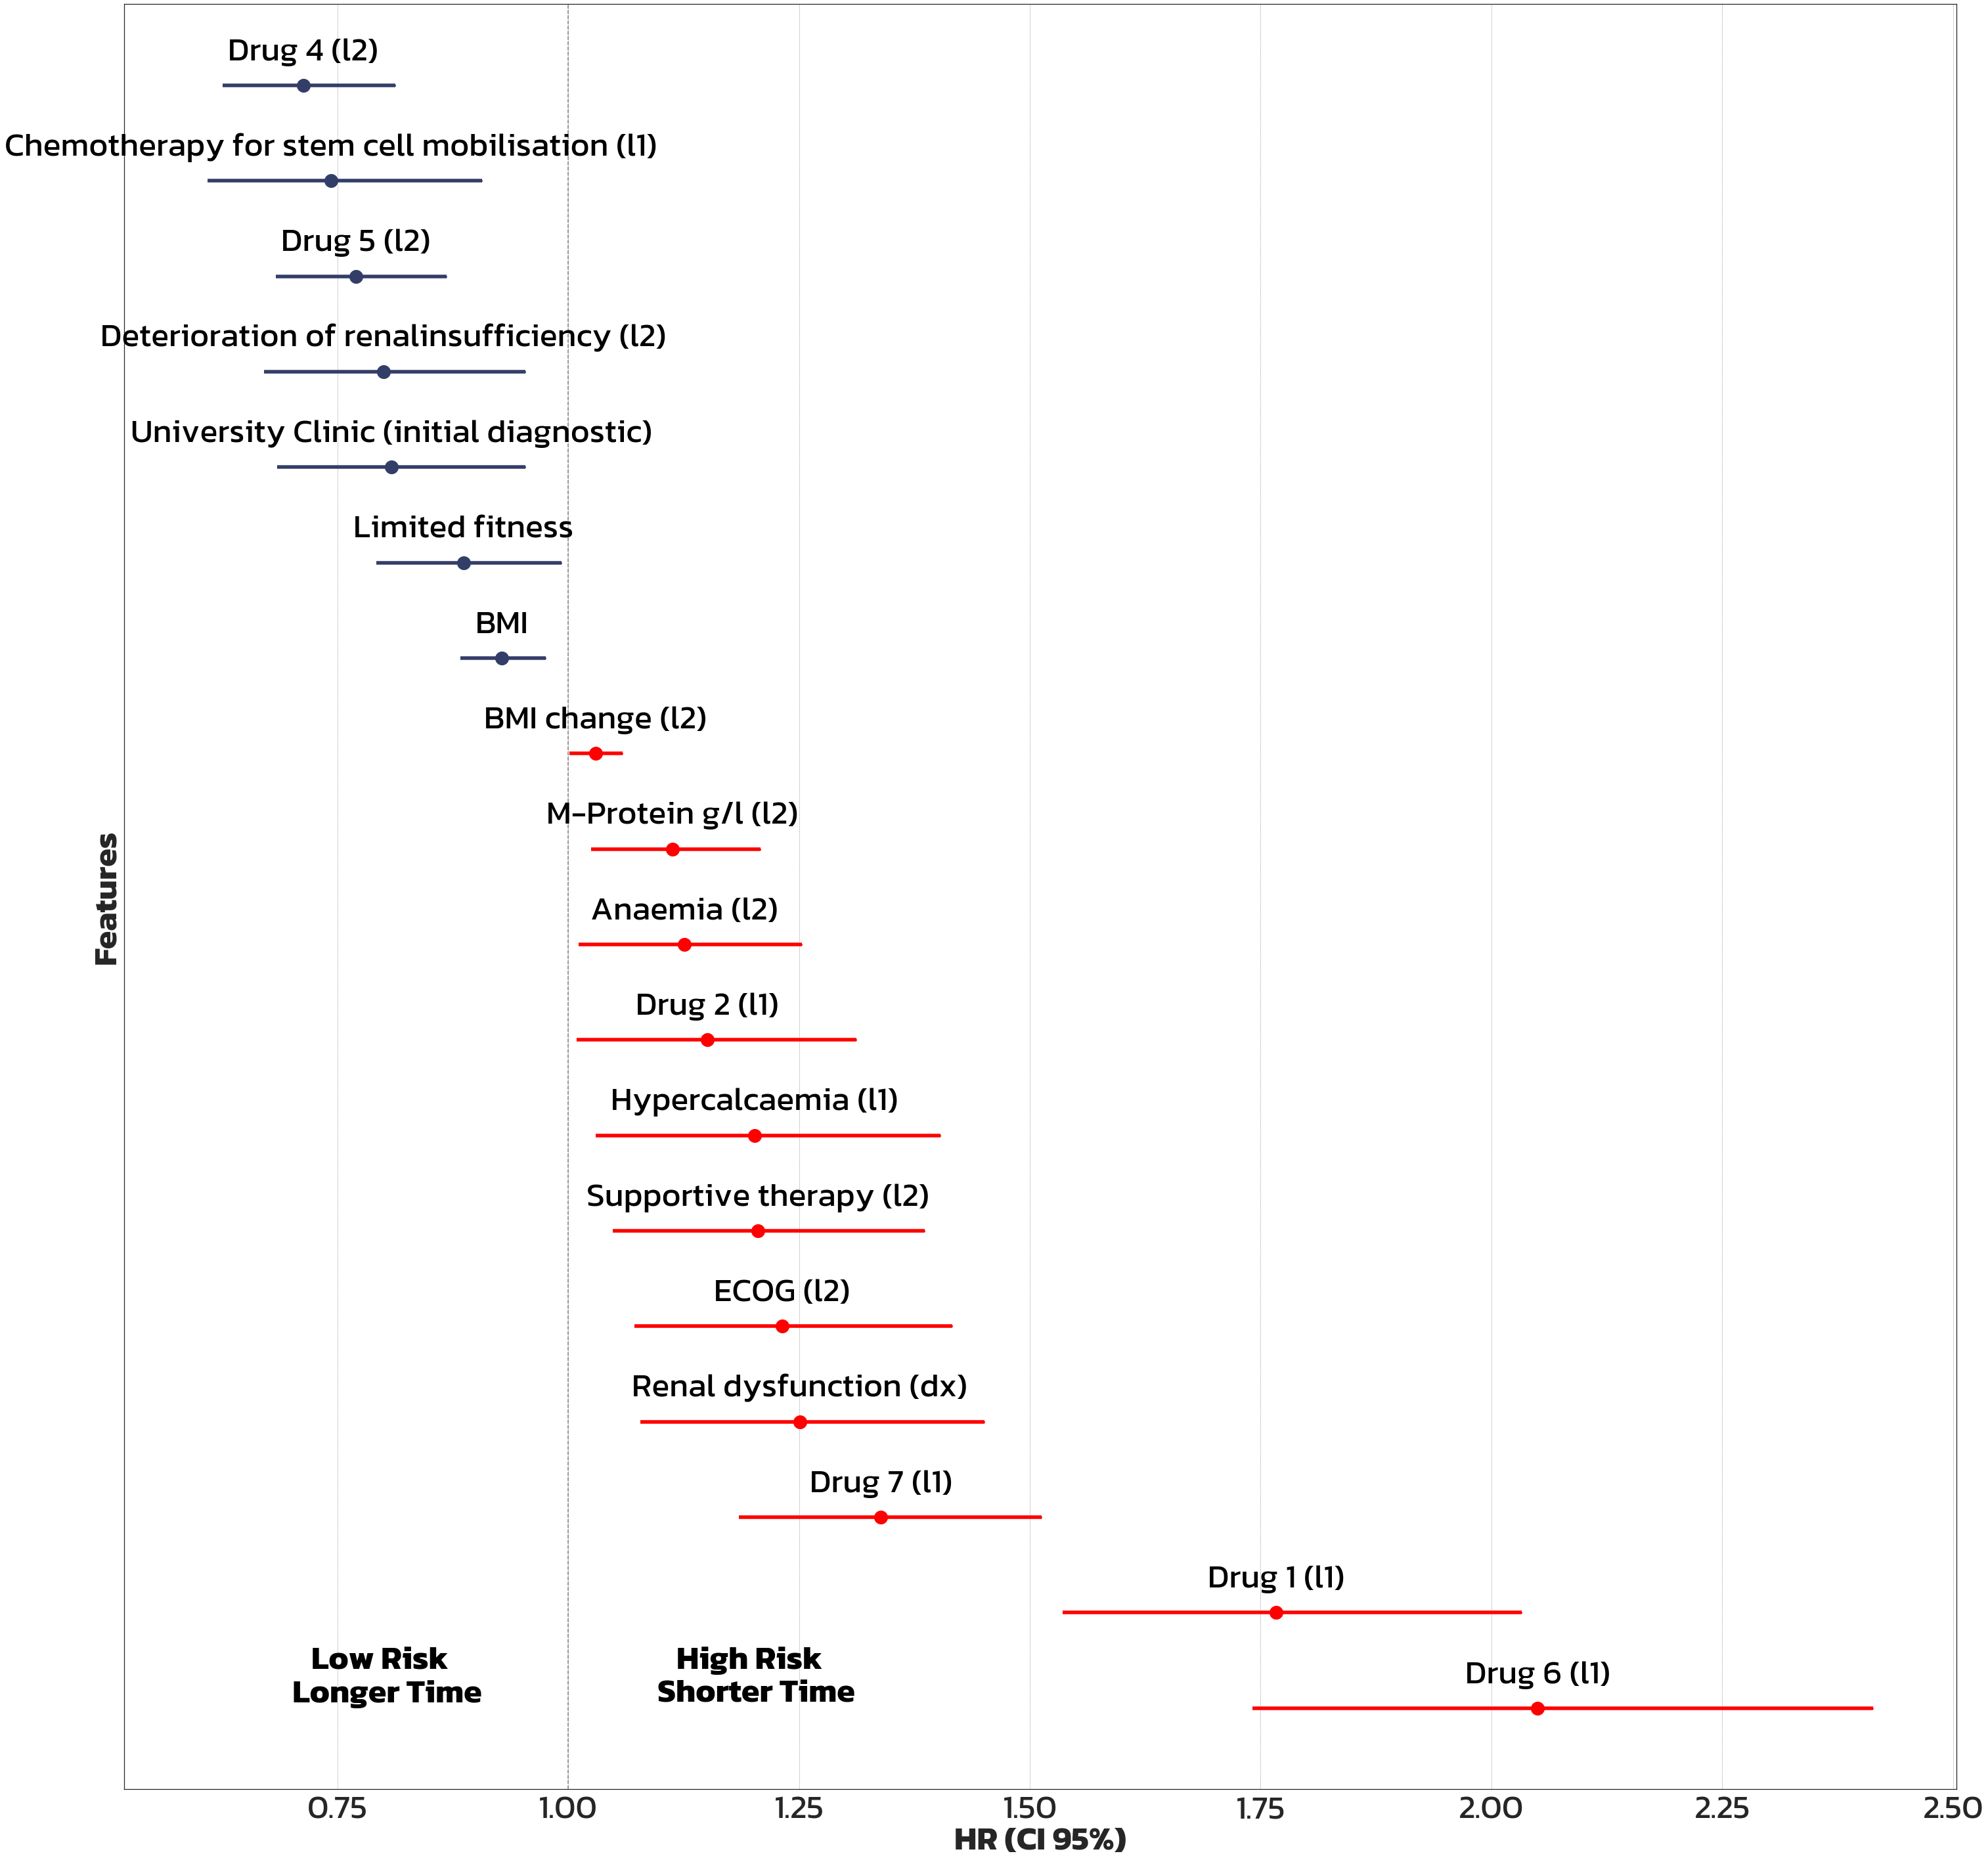

0.6127421370596045 0.6099884976438722
C-index with Lasso less significant features clean-up method:
train: 0.6127421370596045 test: 0.6099884976438722
C-index without Lasso less significant features clean-up method:
train: 0.6160933074794399 test: 0.612207339245297
['training_df', 'training', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'RobustScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 0.6127421370596045, 0.6099884976438722, 0.6160933074794399, 0.612207339245297]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_test_df exist
Directory ../intermediate_report/24-03-18_test_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

 
Data with Nan:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Check if data is in good range for height and weight: 
 
Height <110:
Empt

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/feature_dropping.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/data_preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['event'] = 1
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119:

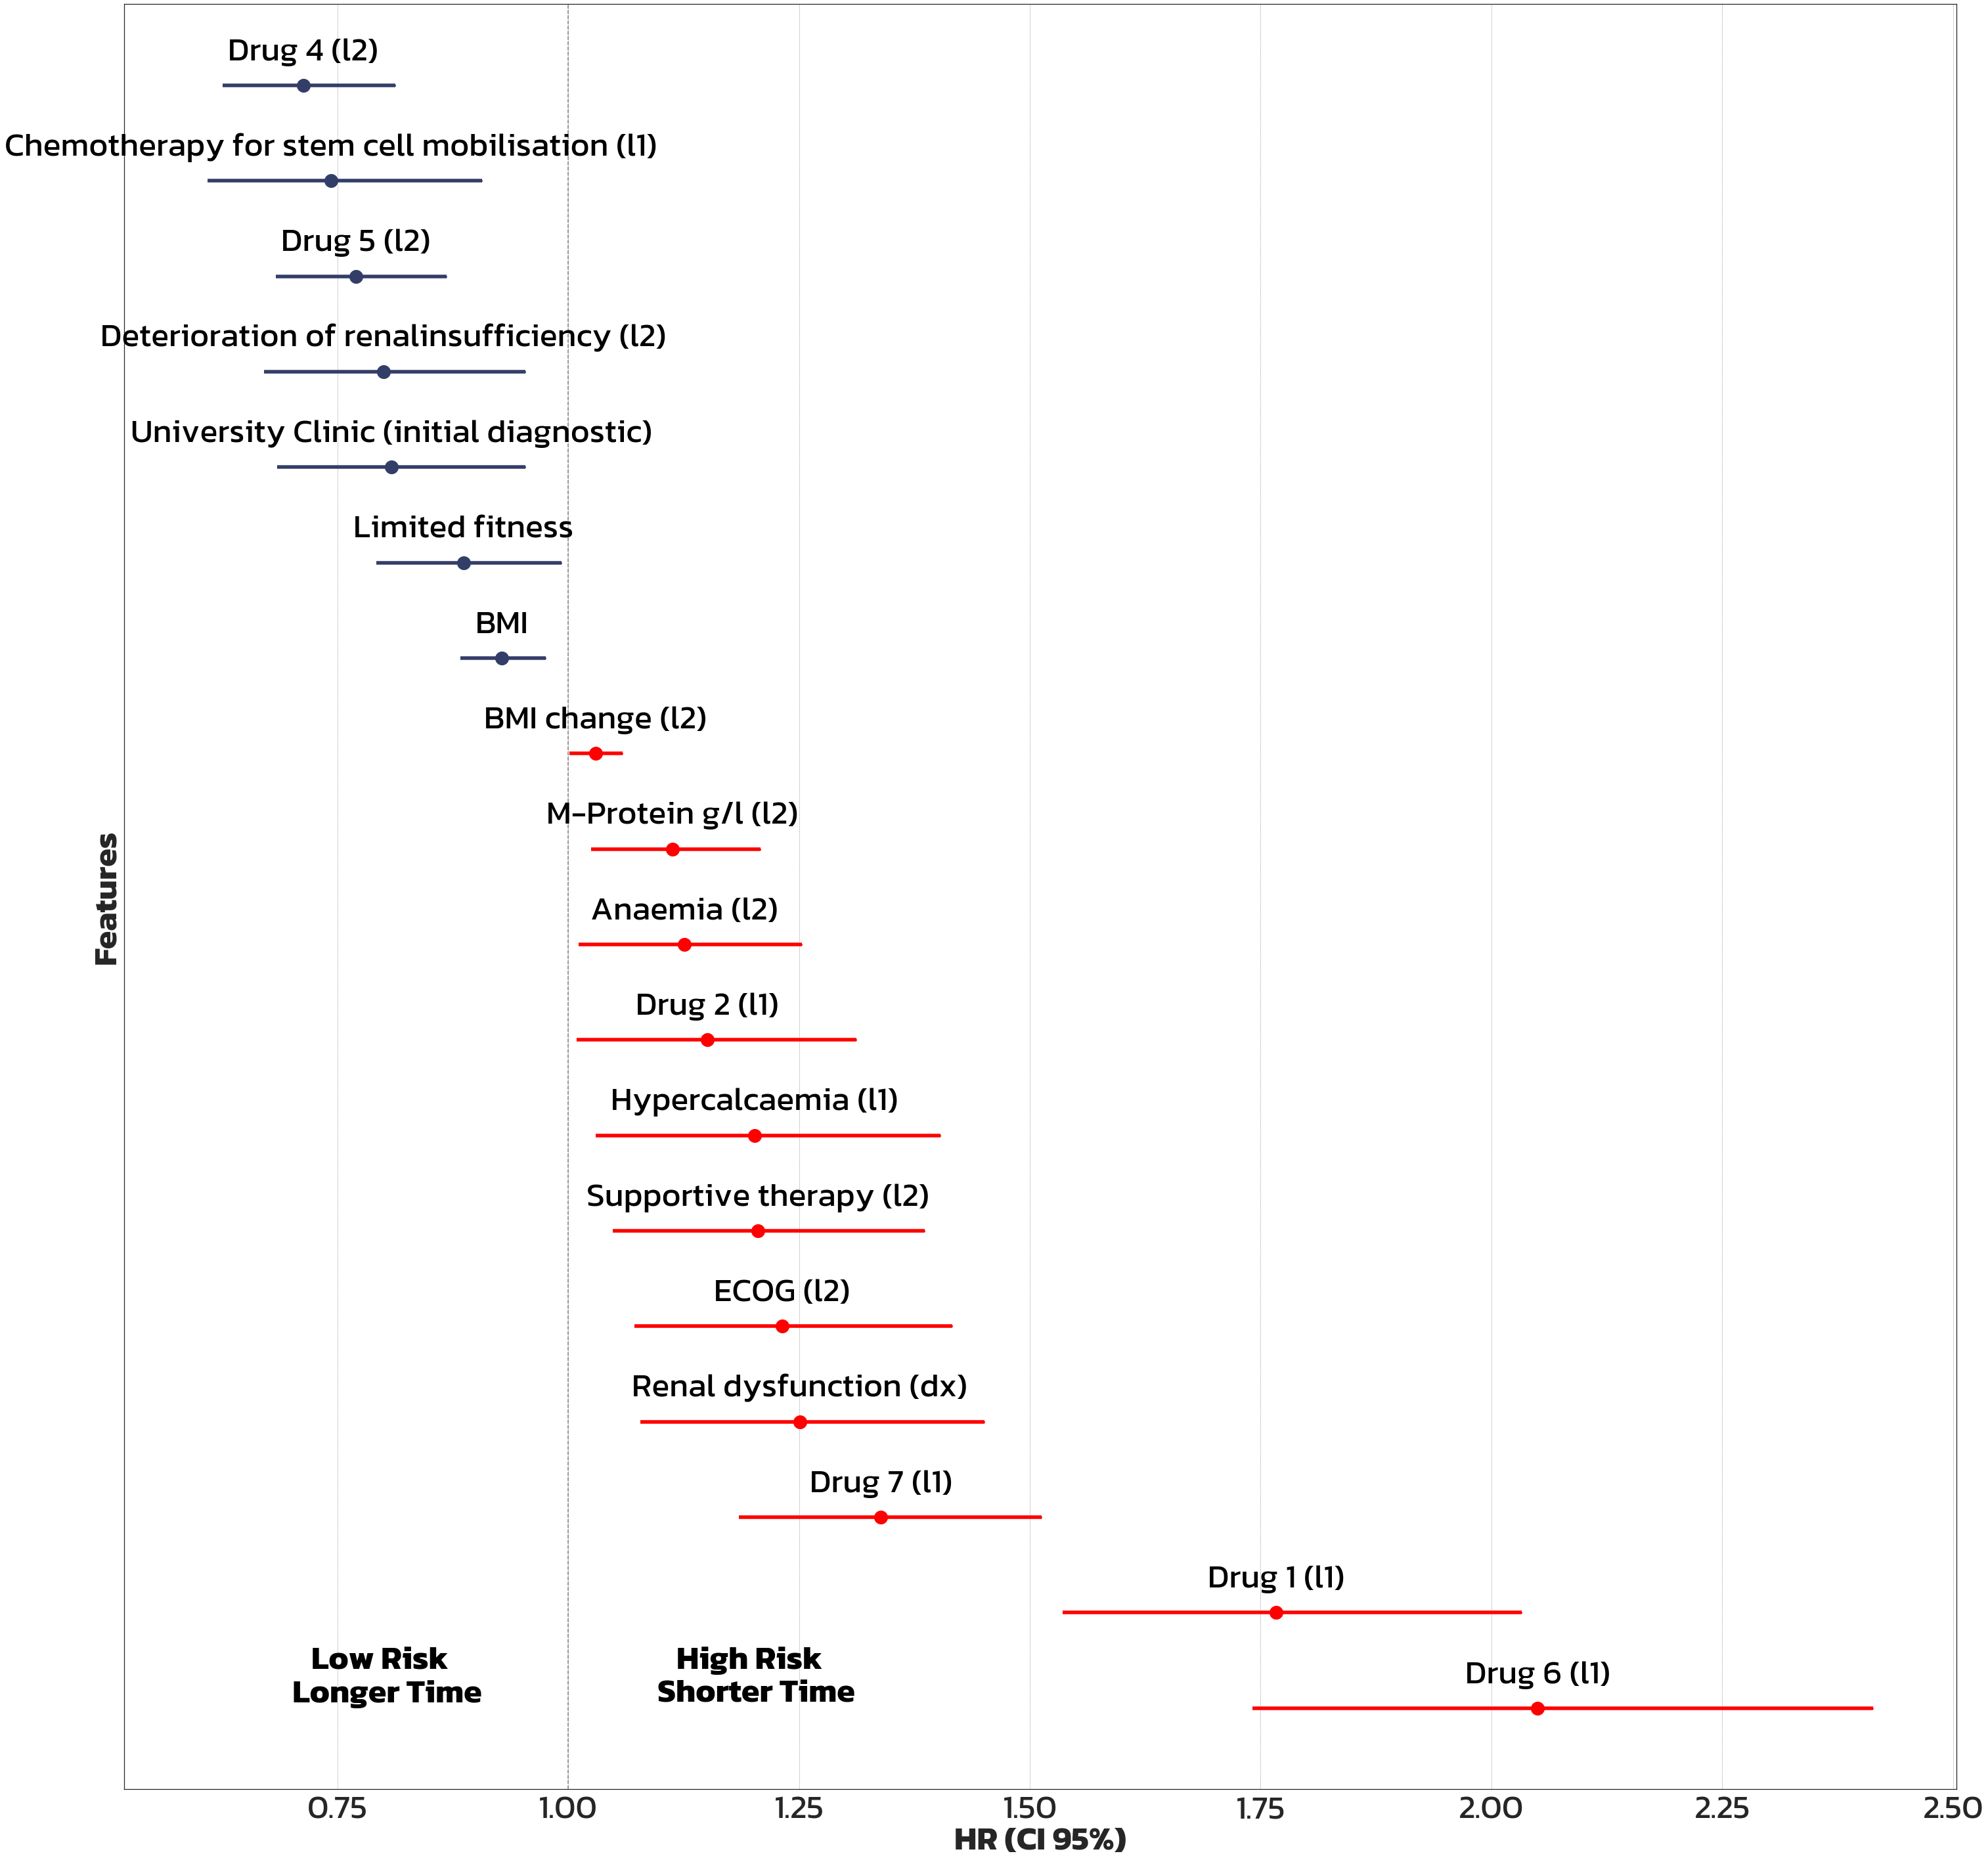

C-index with Lasso less significant features clean-up method:
train: not related test: 0.6097154691157932
C-index without Lasso less significant features clean-up method:
train: not related test: 0.6078532488581111
['test_df', 'test', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'RobustScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 'not related', 0.6097154691157932, 'not related', 0.6078532488581111]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_training_df exist
Directory ../intermediate_report/24-03-18_training_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat'

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


After convertion: 
dx_weight         float64
l1_weight         float64
l2_weight         float64
dx_height         float64
l1_height         float64
l2_height         float64
dx_kofscore       float64
l1_kofscore       float64
l2_kofscore       float64
dx_protg          float64
l1_protg          float64
l2_protg          float64
dx_lightrat       float64
l1_lightrat       float64
l2_lightrat       float64
dx_lightkap       float64
l1_lightkap       float64
l2_lightkap       float64
dx_lightlam       float64
l1_lightlam       float64
l2_lightlam       float64
l1_supperythnr    float64
l2_supperythnr    float64
l1_TTNT           float64
l2_TTNT             int64
dtype: object
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

Wrong data in column dx_BMI:
Series([], Name: dx_BMI, dtype: float64)
Wrong data in column l1_BMI:
Series([], Name: l1_BMI, dtype: float64)
Wrong data in column l2_BMI:
Series([], Name: l2_BMI, dtype: float64)
 
Total number of rows with wrong data: 
(0, 393)
 
Wrong data: 
Empty DataFrame
Columns: [dx_weight, l1_weight, l2_weight, dx_height, l1_height, l2_height]
Index: []
 
BMI_change was added to the dataframe
Control output of used datatype: 
['dx_birthd', 'dx_iddat', 'l1_opdat', 'l2_opdat', 'l1_rtxstartdat', 'l2_rtxstartdat', 'l1_rtxendedat', 'l2_rtxendedat']
START: DDMMYY_type_correction 

1. calculate duration of rtx
2. calculate relative age when patient was diagnosed
dx_iddat_age column was added to dataframe
l1_opdat_age column was added to dataframe
l2_opdat_age column was added to dataframe
3. Drop data ddmmyy-type columns
END: DDMMYY_type_correction 



../intermediate_report/24-03-18_training_df/raw_unique_values_and_missing_count.csv was created
List_ordinary_values:
['d

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


             covariate                                  feature_name
0       bin__l1_drug_6                                   Drug 6 (l1)
1       bin__l1_drug_1                                   Drug 1 (l1)
2       bin__l1_drug_7                                   Drug 7 (l1)
3      bin__l2_ecogbin                                     ECOG (l2)
4   num__l2_BMI_change                               BMI change (l2)
5    bin__l2_suppdurch                       Supportive therapy (l2)
6    bin__l1_crabkritc                           Hypercalcaemia (l1)
7      cat__l1_iss_3.0                          ISS Stadium III (l1)
8          num__dx_BMI                                           BMI
9   cat__dx_einrid_1.0        University Clinic (initial diagnostic)
10      bin__l2_drug_5                                   Drug 5 (l2)
11     bin__l1_smdurch  Chemotherapy for stem cell mobilisation (l1)
12      bin__l2_drug_4                                   Drug 4 (l2)


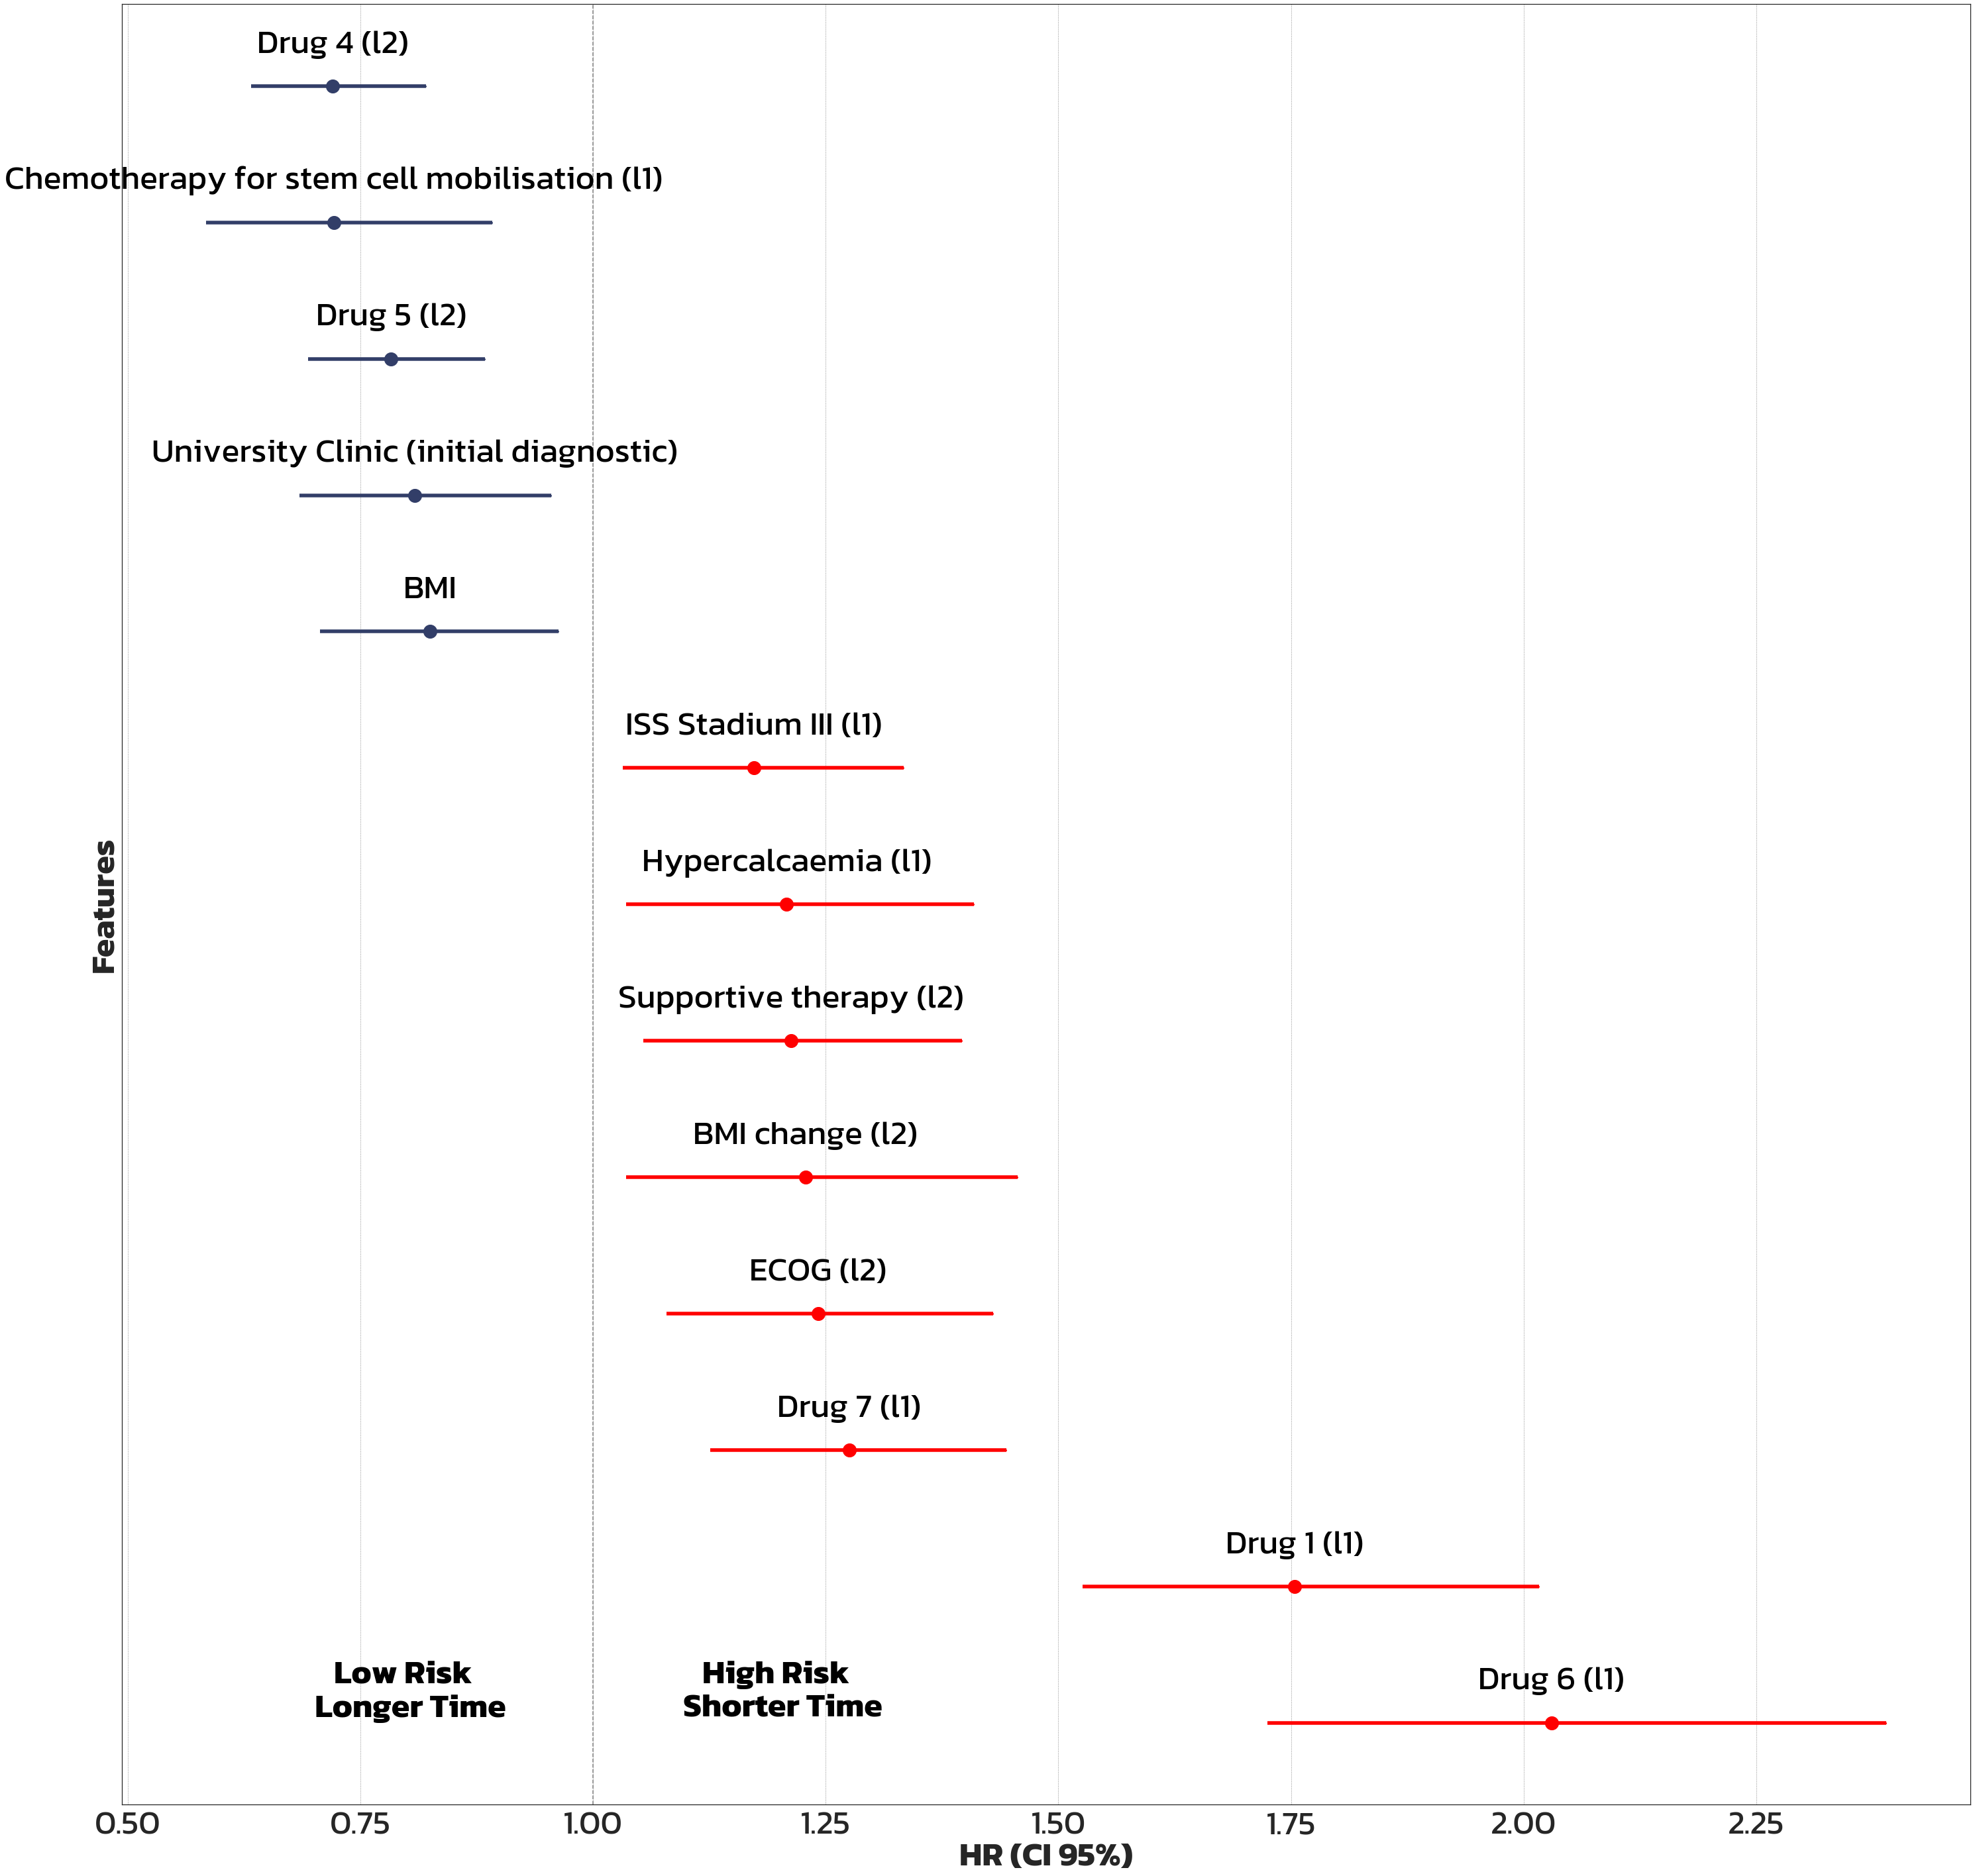

0.6146045160316065 0.6135727802307892
C-index with Lasso less significant features clean-up method:
train: 0.6146045160316065 test: 0.6135727802307892
C-index without Lasso less significant features clean-up method:
train: 0.6161878045097318 test: 0.611480093503024
['training_df', 'training', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'QuantileTransformer()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 0.6146045160316065, 0.6135727802307892, 0.6161878045097318, 0.611480093503024]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_test_df exist
Directory ../intermediate_report/24-03-18_test_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Check if data is in good range for height and weight: 
 
Height <110:
Empty DataFrame
Columns: [dx_weight, l1_weight, l2_weight, dx_height, l1_height, l2_height]
Index: []
 
Weight >140:
     dx_weight  l1_weight  l2_weight  dx_height  l1_height  l2_height
437      150.0      147.0      147.0      19

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/feature_dropping.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/data_preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['event'] = 1
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119:

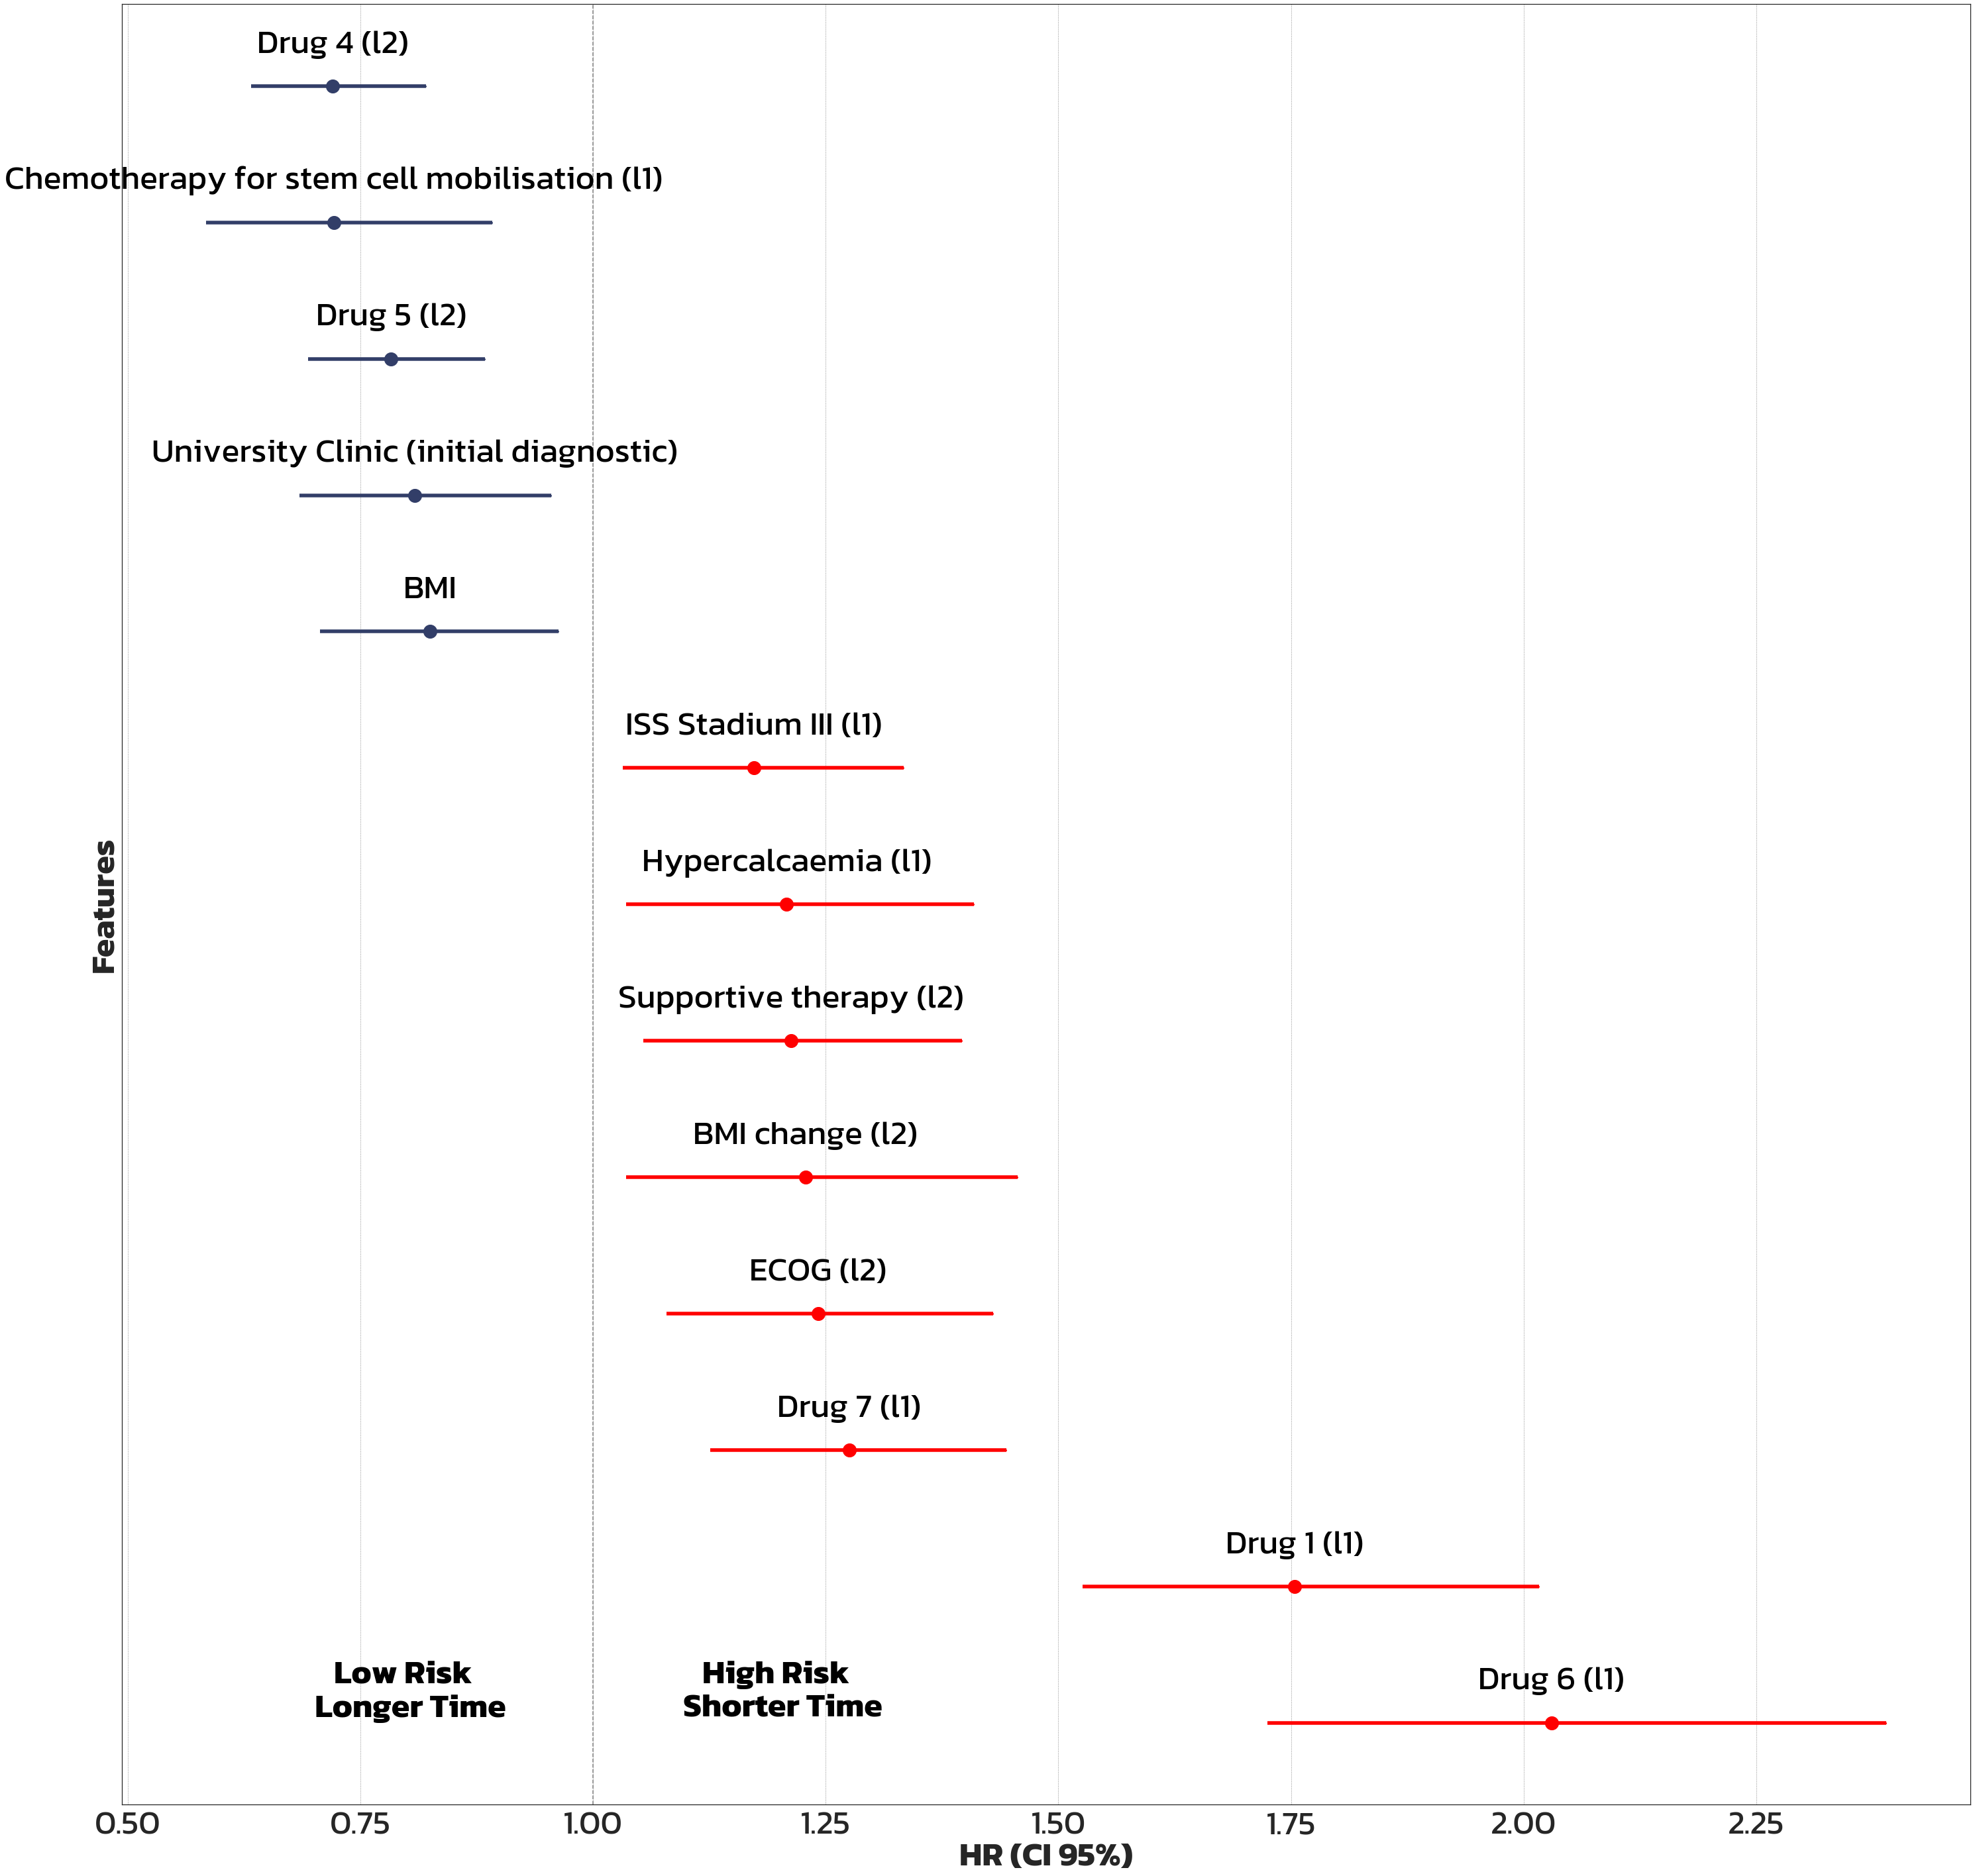

C-index with Lasso less significant features clean-up method:
train: not related test: 0.6120115253016387
C-index without Lasso less significant features clean-up method:
train: not related test: 0.6076445164775797
['test_df', 'test', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'QuantileTransformer()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 'not related', 0.6120115253016387, 'not related', 0.6076445164775797]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_training_df exist
Directory ../intermediate_report/24-03-18_training_df/figures exist


/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2_lightlam', 'l1_supperythnr', 'l2_supperythnr', 'l1_TTNT', 'l2_TTNT']
dx_weight         float64
l1_weight         float64
l2_weight         float64
dx_height         float64
l1_height         float64
l2_height         float64
dx_kofscore       float64
l1_kofscore       float64
l2_kofscore       float64
dx_protg          float64
l1_protg          float64
l2_protg          float64
dx_lightrat        object
l1_lightrat        object
l2_lightrat        object
dx_lightkap        object
l1_lightkap        object
l2_lightkap        object
dx_lightlam        object
l1_lightlam        object
l2_lightlam        object
l1_supperythnr    float64
l2_supperythnr    flo

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

Weight Correction: 
 
Data with Nan:
   dx_weight  l1_weight  l2_weight
0       50.0       50.0       50.0
1       64.0       64.0       59.0
2        NaN        NaN       64.0
3       55.0       55.0       55.0
4       72.0       72.0       72.0
 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       50.0       50.0       50.0
1       64.0       64.0       59.0
2       64.0       64.0       64.0
3       55.0       55.0       55.0
4       72.0       72.0       72.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      150.0      150.0      150.0
1      171.0      171.0      171.0
2        NaN        NaN      180.0
3      158.0      158.0      158.0
4      175.0      175.0      175.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      150.0      150.0      150.0
1      171.0      171.0      171.0
2      180.0      180.0      180.0
3      158.0      158.0      158.0
4      175.0      175.0      175.0
 
Check if data is in good range for height and weight: 

/Users/tatiana/anaconda3/envs/MLG/lib/python3.10/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['num__l1_BMI_change', 'num__l2_BMI_change'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


['num__dx_protg', 'num__l1_TTNT', 'num__l1_BMI_change', 'cat__l2_rtptheraentsch_1.0', 'cat__l2_rtptheraentsch_2.0', 'cat__l2_rtptheraentsch_3.0', 'cat__dx_versi_1.0', 'cat__dx_versi_2.0', 'cat__dx_versi_3.0', 'cat__dx_mmtyp_1.0', 'cat__dx_mmtyp_10.0', 'cat__dx_prottyp_1.0', 'cat__dx_prottyp_2.0', 'cat__dx_prottyp_10.0', 'cat__l1_prottyp_1.0', 'cat__l1_prottyp_10.0', 'cat__l2_prottyp_2.0', 'cat__l2_prottyp_10.0', 'cat__dx_einrverd_2.0', 'cat__dx_einrverd_3.0', 'cat__dx_einrverd_4.0', 'cat__dx_einrverd_5.0', 'cat__dx_fachverd_1.0', 'cat__dx_fachverd_3.0', 'cat__dx_fachverd_4.0', 'cat__dx_fachverd_10.0', 'cat__dx_einrid_2.0', 'cat__dx_einrid_10.0', 'cat__dx_fachid_1.0', 'cat__dx_fachid_3.0', 'cat__l1_fit_1.0', 'cat__l1_fit_3.0', 'cat__l2_fit_1.0', 'cat__dx_dusa_1.0', 'cat__dx_dusa_2.0', 'cat__l1_dusa_1.0', 'cat__l1_dusa_3.0', 'cat__dx_iss_1.0', 'cat__dx_iss_2.0', 'cat__dx_iss_3.0', 'cat__l1_iss_1.0', 'cat__l1_iss_2.0', 'cat__l2_iss_2.0', 'cat__l2_iss_3.0', 'bin__l2_rtpnotwmprot', 'bin__l2

/Users/tatiana/anaconda3/envs/MLG/lib/python3.10/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['num__l2_BMI_change'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


['cat__l2_fit_3.0', 'cat__l2_iss_1.0', 'bin__l1_drug_11']
(2080, 46)


/Users/tatiana/anaconda3/envs/MLG/lib/python3.10/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['num__l2_BMI_change'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


[]
(2080, 43)


/Users/tatiana/anaconda3/envs/MLG/lib/python3.10/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['num__l2_BMI_change'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


             covariate                            feature_name
0        num__l2_protg                      M-Protein g/l (l2)
1       bin__l1_drug_6                             Drug 6 (l1)
2       bin__l1_drug_1                             Drug 1 (l1)
3      bin__l2_ecogbin                               ECOG (l2)
4       bin__l1_drug_7                             Drug 7 (l1)
5     cat__dx_dusa_3.0                        Stadium III (dx)
6    bin__l1_crabkritc                     Hypercalcaemia (l1)
7    bin__l2_suppdurch                 Supportive therapy (l2)
8      cat__l1_iss_3.0                    ISS Stadium III (l1)
9    bin__l2_crabkrita                            Anaemia (l2)
10  cat__dx_einrid_1.0  University Clinic (initial diagnostic)
11      bin__l2_drug_5                             Drug 5 (l2)
12      bin__l2_drug_4                             Drug 4 (l2)
13         num__dx_BMI                                     BMI


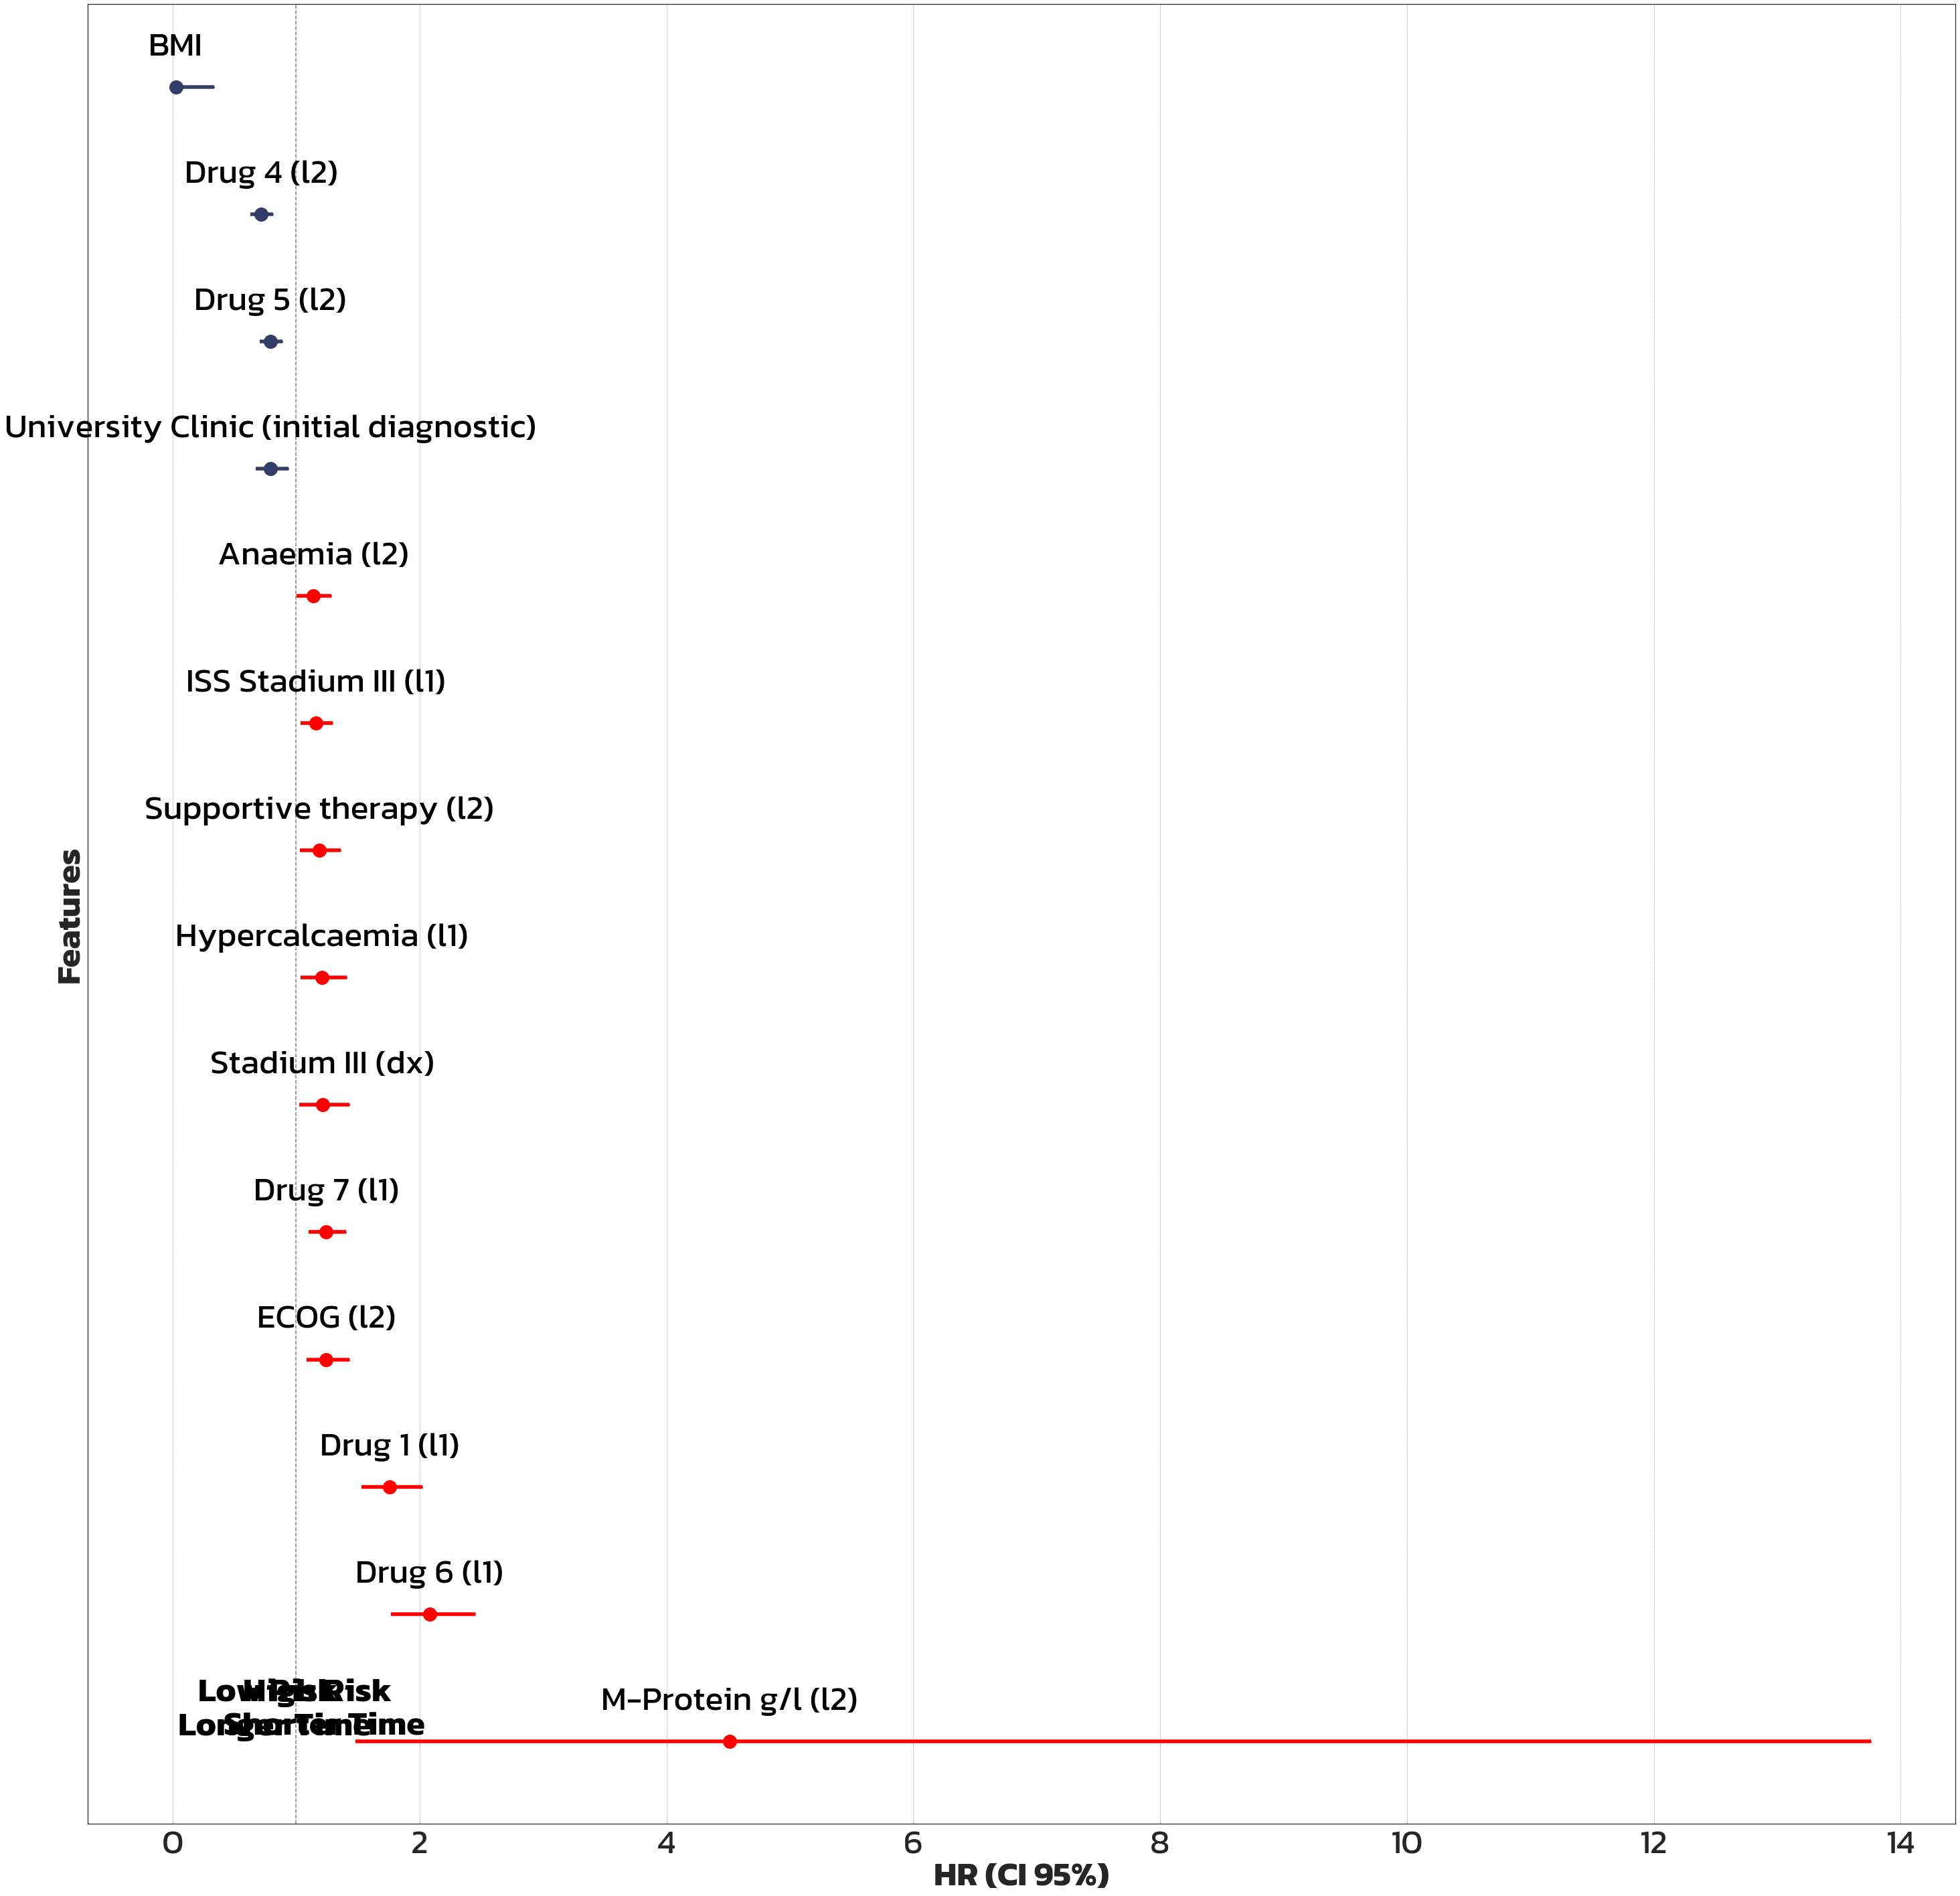

0.6148764266040639 0.6115839857519202
C-index with Lasso less significant features clean-up method:
train: 0.6148764266040639 test: 0.6115839857519202


/Users/tatiana/anaconda3/envs/MLG/lib/python3.10/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['num__l1_BMI_change', 'num__l2_BMI_change'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


C-index without Lasso less significant features clean-up method:
train: 0.6162155977539353 test: 0.6126822752402509
['training_df', 'training', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'Normalizer()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 0.6148764266040639, 0.6115839857519202, 0.6162155977539353, 0.6126822752402509]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_test_df exist
Directory ../intermediate_report/24-03-18_test_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam',

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows


 
Data with Nan:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Check if data is in good range for height and weight: 
 
Height <110:
Emp

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/feature_dropping.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/data_preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['event'] = 1
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119:

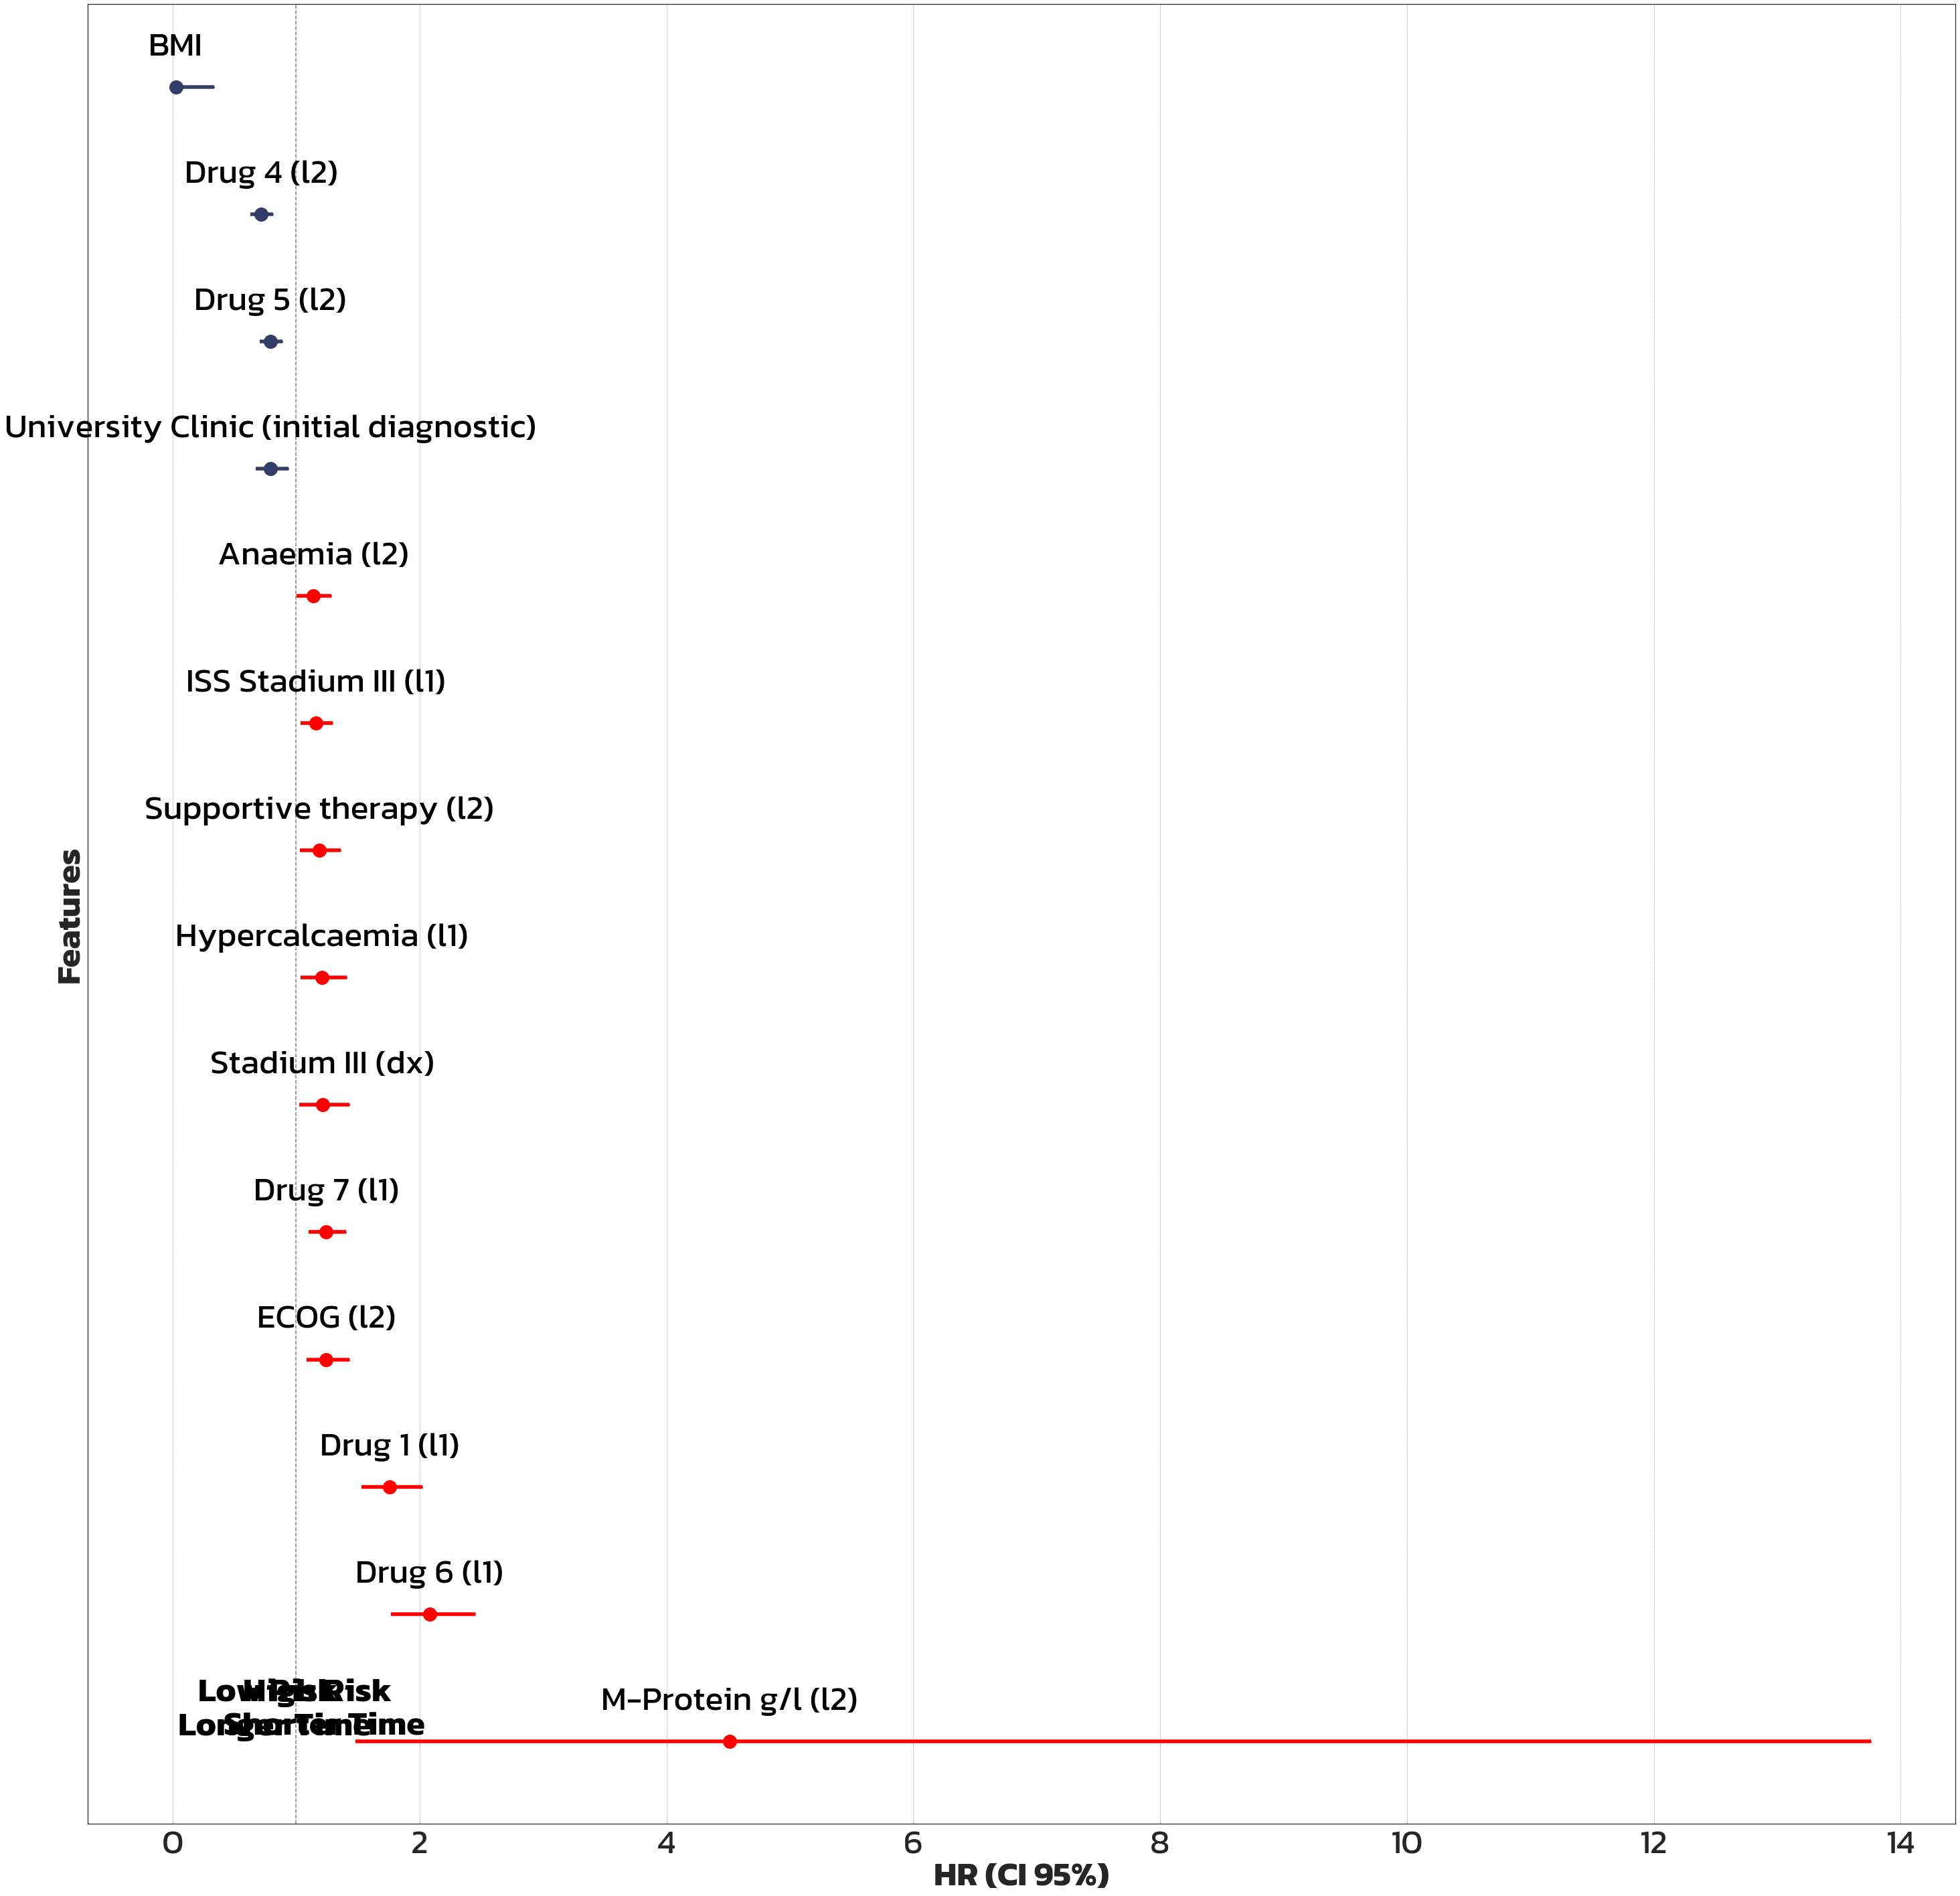

C-index with Lasso less significant features clean-up method:
train: not related test: 0.6058723376389503
C-index without Lasso less significant features clean-up method:
train: not related test: 0.6034698688669515
['test_df', 'test', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'Normalizer()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 'not related', 0.6058723376389503, 'not related', 0.6034698688669515]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_training_df exist
Directory ../intermediate_report/24-03-18_training_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


After convertion: 
dx_weight         float64
l1_weight         float64
l2_weight         float64
dx_height         float64
l1_height         float64
l2_height         float64
dx_kofscore       float64
l1_kofscore       float64
l2_kofscore       float64
dx_protg          float64
l1_protg          float64
l2_protg          float64
dx_lightrat       float64
l1_lightrat       float64
l2_lightrat       float64
dx_lightkap       float64
l1_lightkap       float64
l2_lightkap       float64
dx_lightlam       float64
l1_lightlam       float64
l2_lightlam       float64
l1_supperythnr    float64
l2_supperythnr    float64
l1_TTNT           float64
l2_TTNT             int64
dtype: object
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

 
Total number of rows with wrong data: 
(7, 393)
 
Wrong data: 
      dx_weight  l1_weight  l2_weight  dx_height  l1_height  l2_height
389        69.0      171.0       68.0      170.0       69.0      171.0
593       163.0      163.0       80.0      180.0       80.0      163.0
1129       90.0      185.0      185.0      185.0       80.0       80.0
1403       85.0      165.0       85.0      165.0       85.0      165.0
1779       88.0      176.0       90.0      176.0       88.0      176.0
550        81.0       81.0       76.0      169.0      169.0       68.0
1129       90.0      185.0      185.0      185.0       80.0       80.0
 
Corrected data: 
      dx_weight  l1_weight  l2_weight  dx_height  l1_height  l2_height
389        69.0       69.0       68.0      170.0      171.0      171.0
593        80.0       80.0       80.0      163.0      163.0      163.0
1129       90.0       80.0       80.0      185.0      185.0      185.0
1403       85.0       85.0       85.0      165.0      165.0     

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


                  covariate                                  feature_name
0        num__l2_BMI_change                               BMI change (l2)
1            bin__l1_drug_6                                   Drug 6 (l1)
2            bin__l1_drug_1                                   Drug 1 (l1)
3             num__l2_protg                            M-Protein g/l (l2)
4            bin__l1_drug_7                                   Drug 7 (l1)
5         bin__dx_crabkritr                        Renal dysfunction (dx)
6           bin__l2_ecogbin                                     ECOG (l2)
7         bin__l2_suppdurch                       Supportive therapy (l2)
8         bin__l1_crabkritc                           Hypercalcaemia (l1)
9            bin__l1_drug_2                                   Drug 2 (l1)
10        bin__l2_crabkrita                                  Anaemia (l2)
11          cat__l2_fit_2.0                               Limited fitness
12       cat__dx_einrid_1.0        Uni

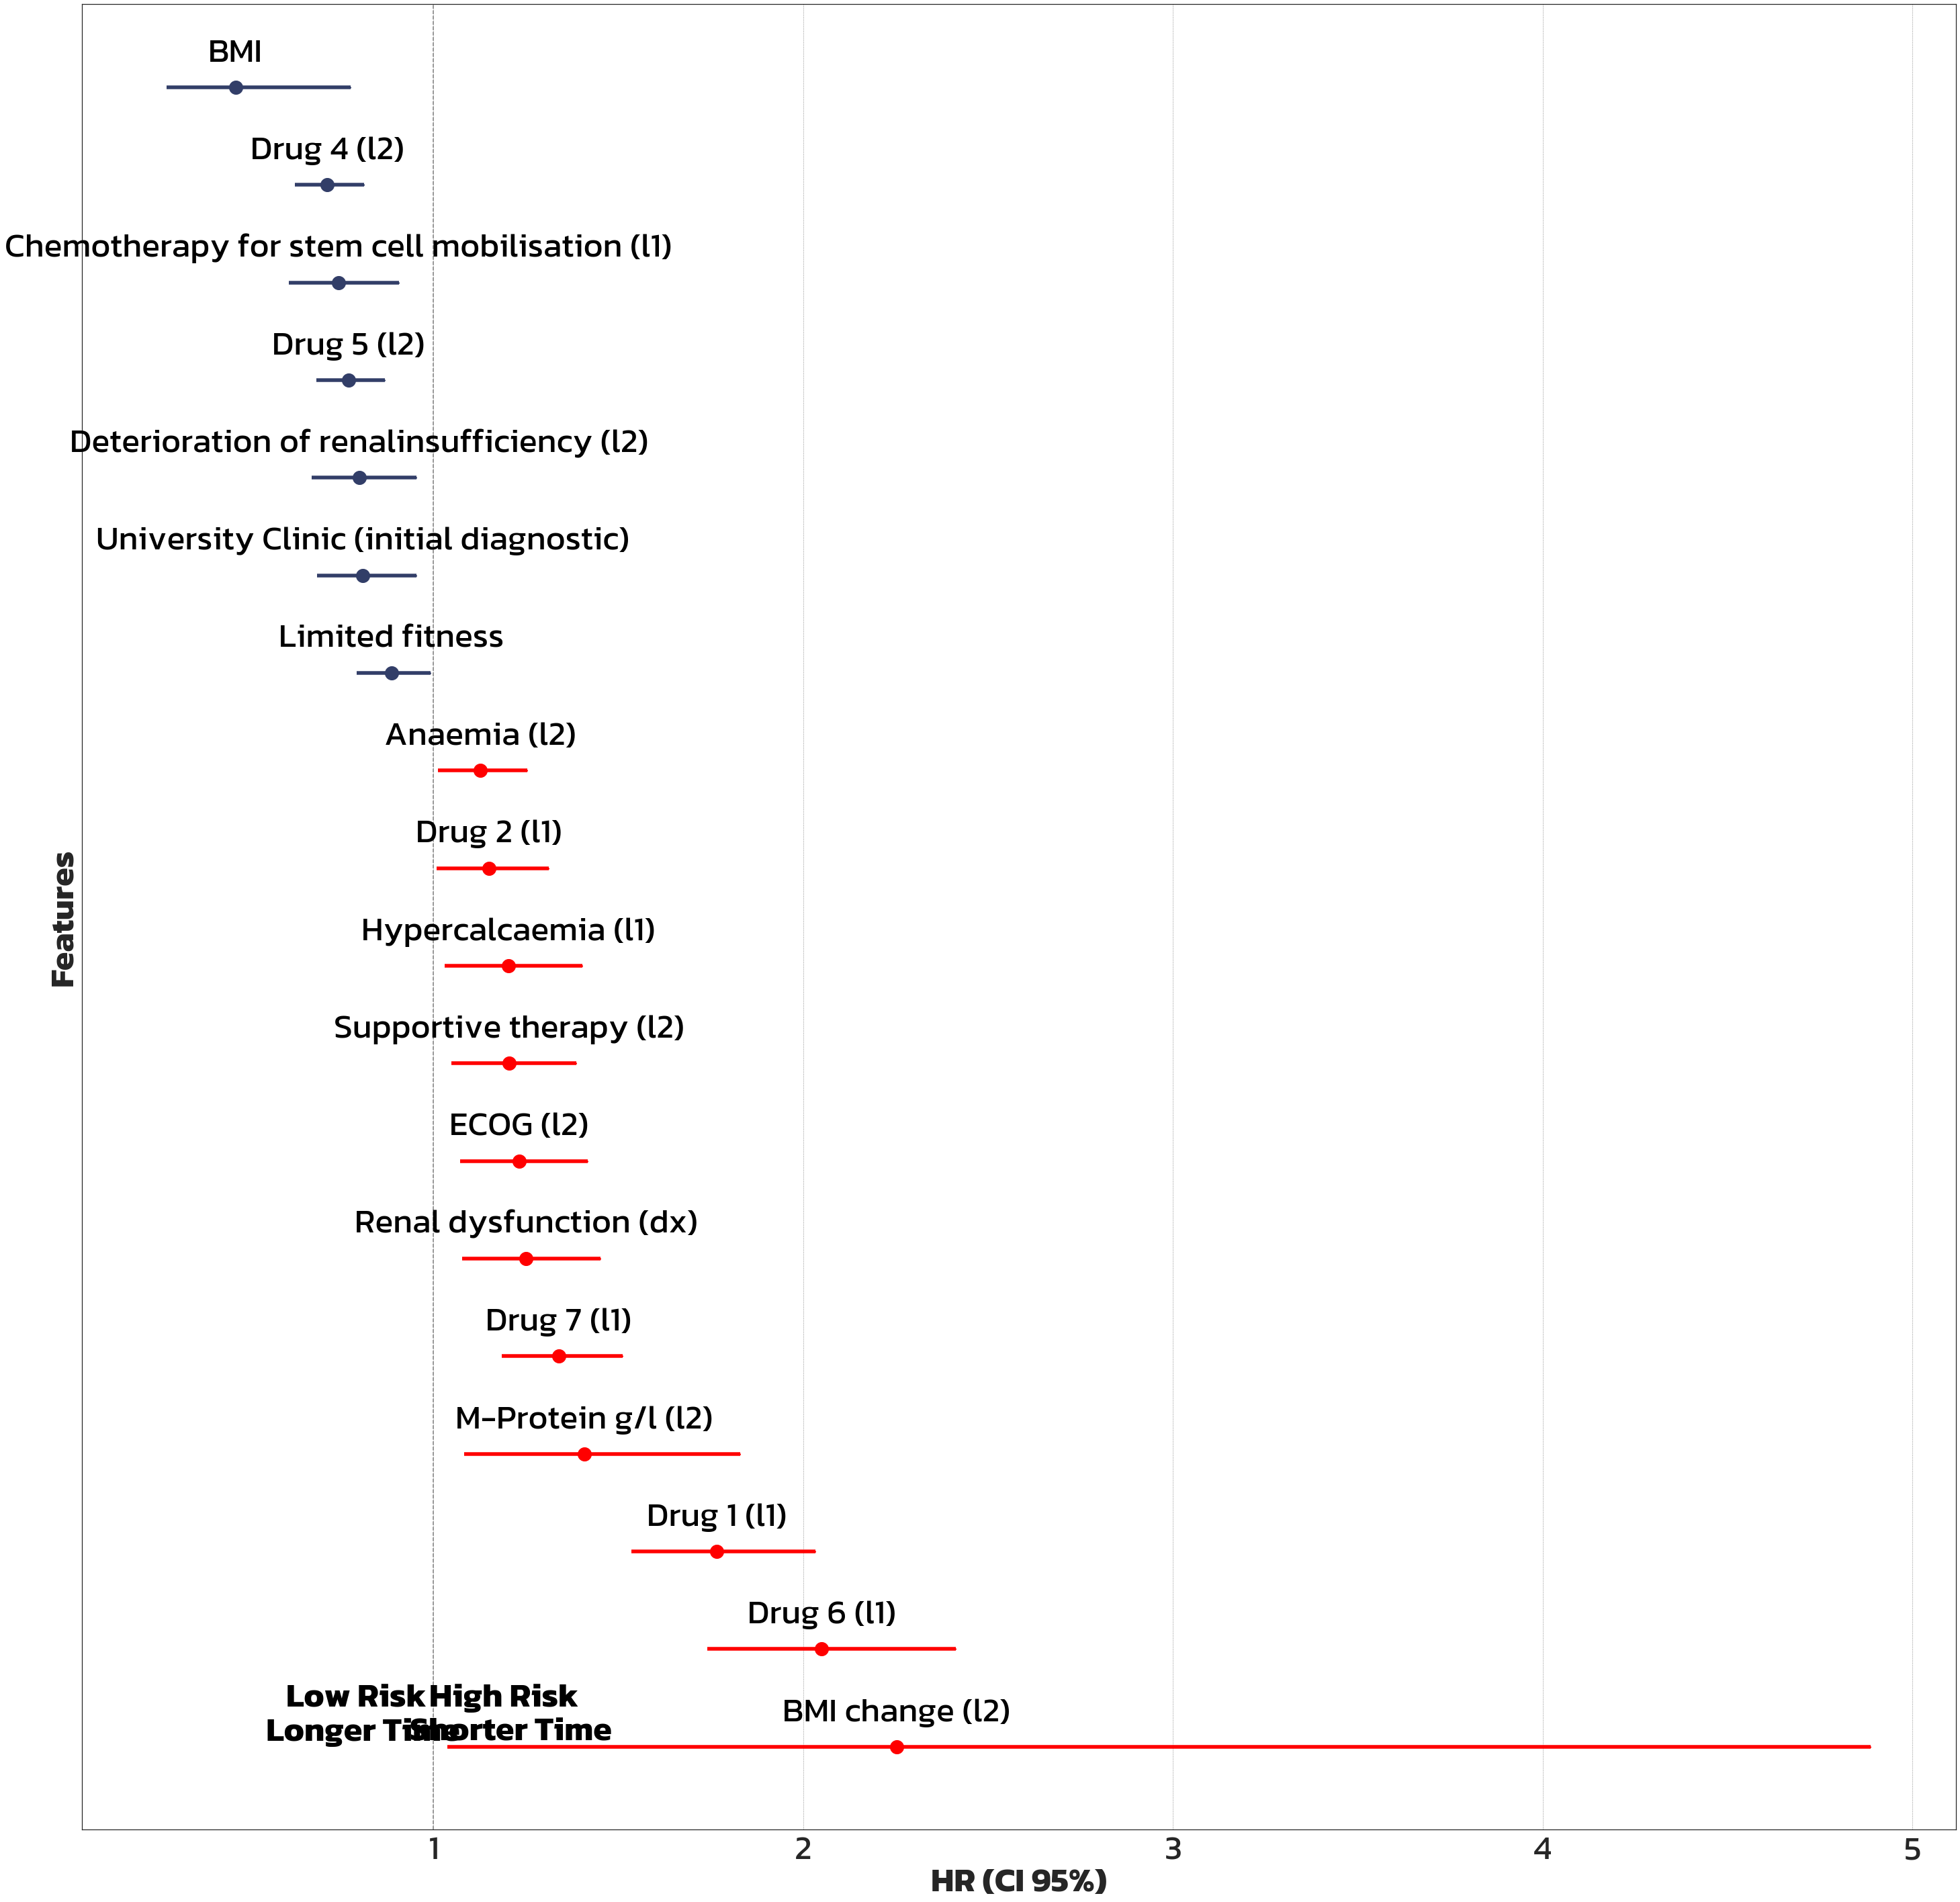

0.6127421370596045 0.6099884976438722
C-index with Lasso less significant features clean-up method:
train: 0.6127421370596045 test: 0.6099884976438722
C-index without Lasso less significant features clean-up method:
train: 0.6160933074794399 test: 0.612207339245297
['training_df', 'training', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'MaxAbsScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 0.6127421370596045, 0.6099884976438722, 0.6160933074794399, 0.612207339245297]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_test_df exist
Directory ../intermediate_report/24-03-18_test_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows


 
Data with Nan:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Check if data is in good range for height and weight: 
 
Height <110:
Emp

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/feature_dropping.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/data_preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['event'] = 1
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119:

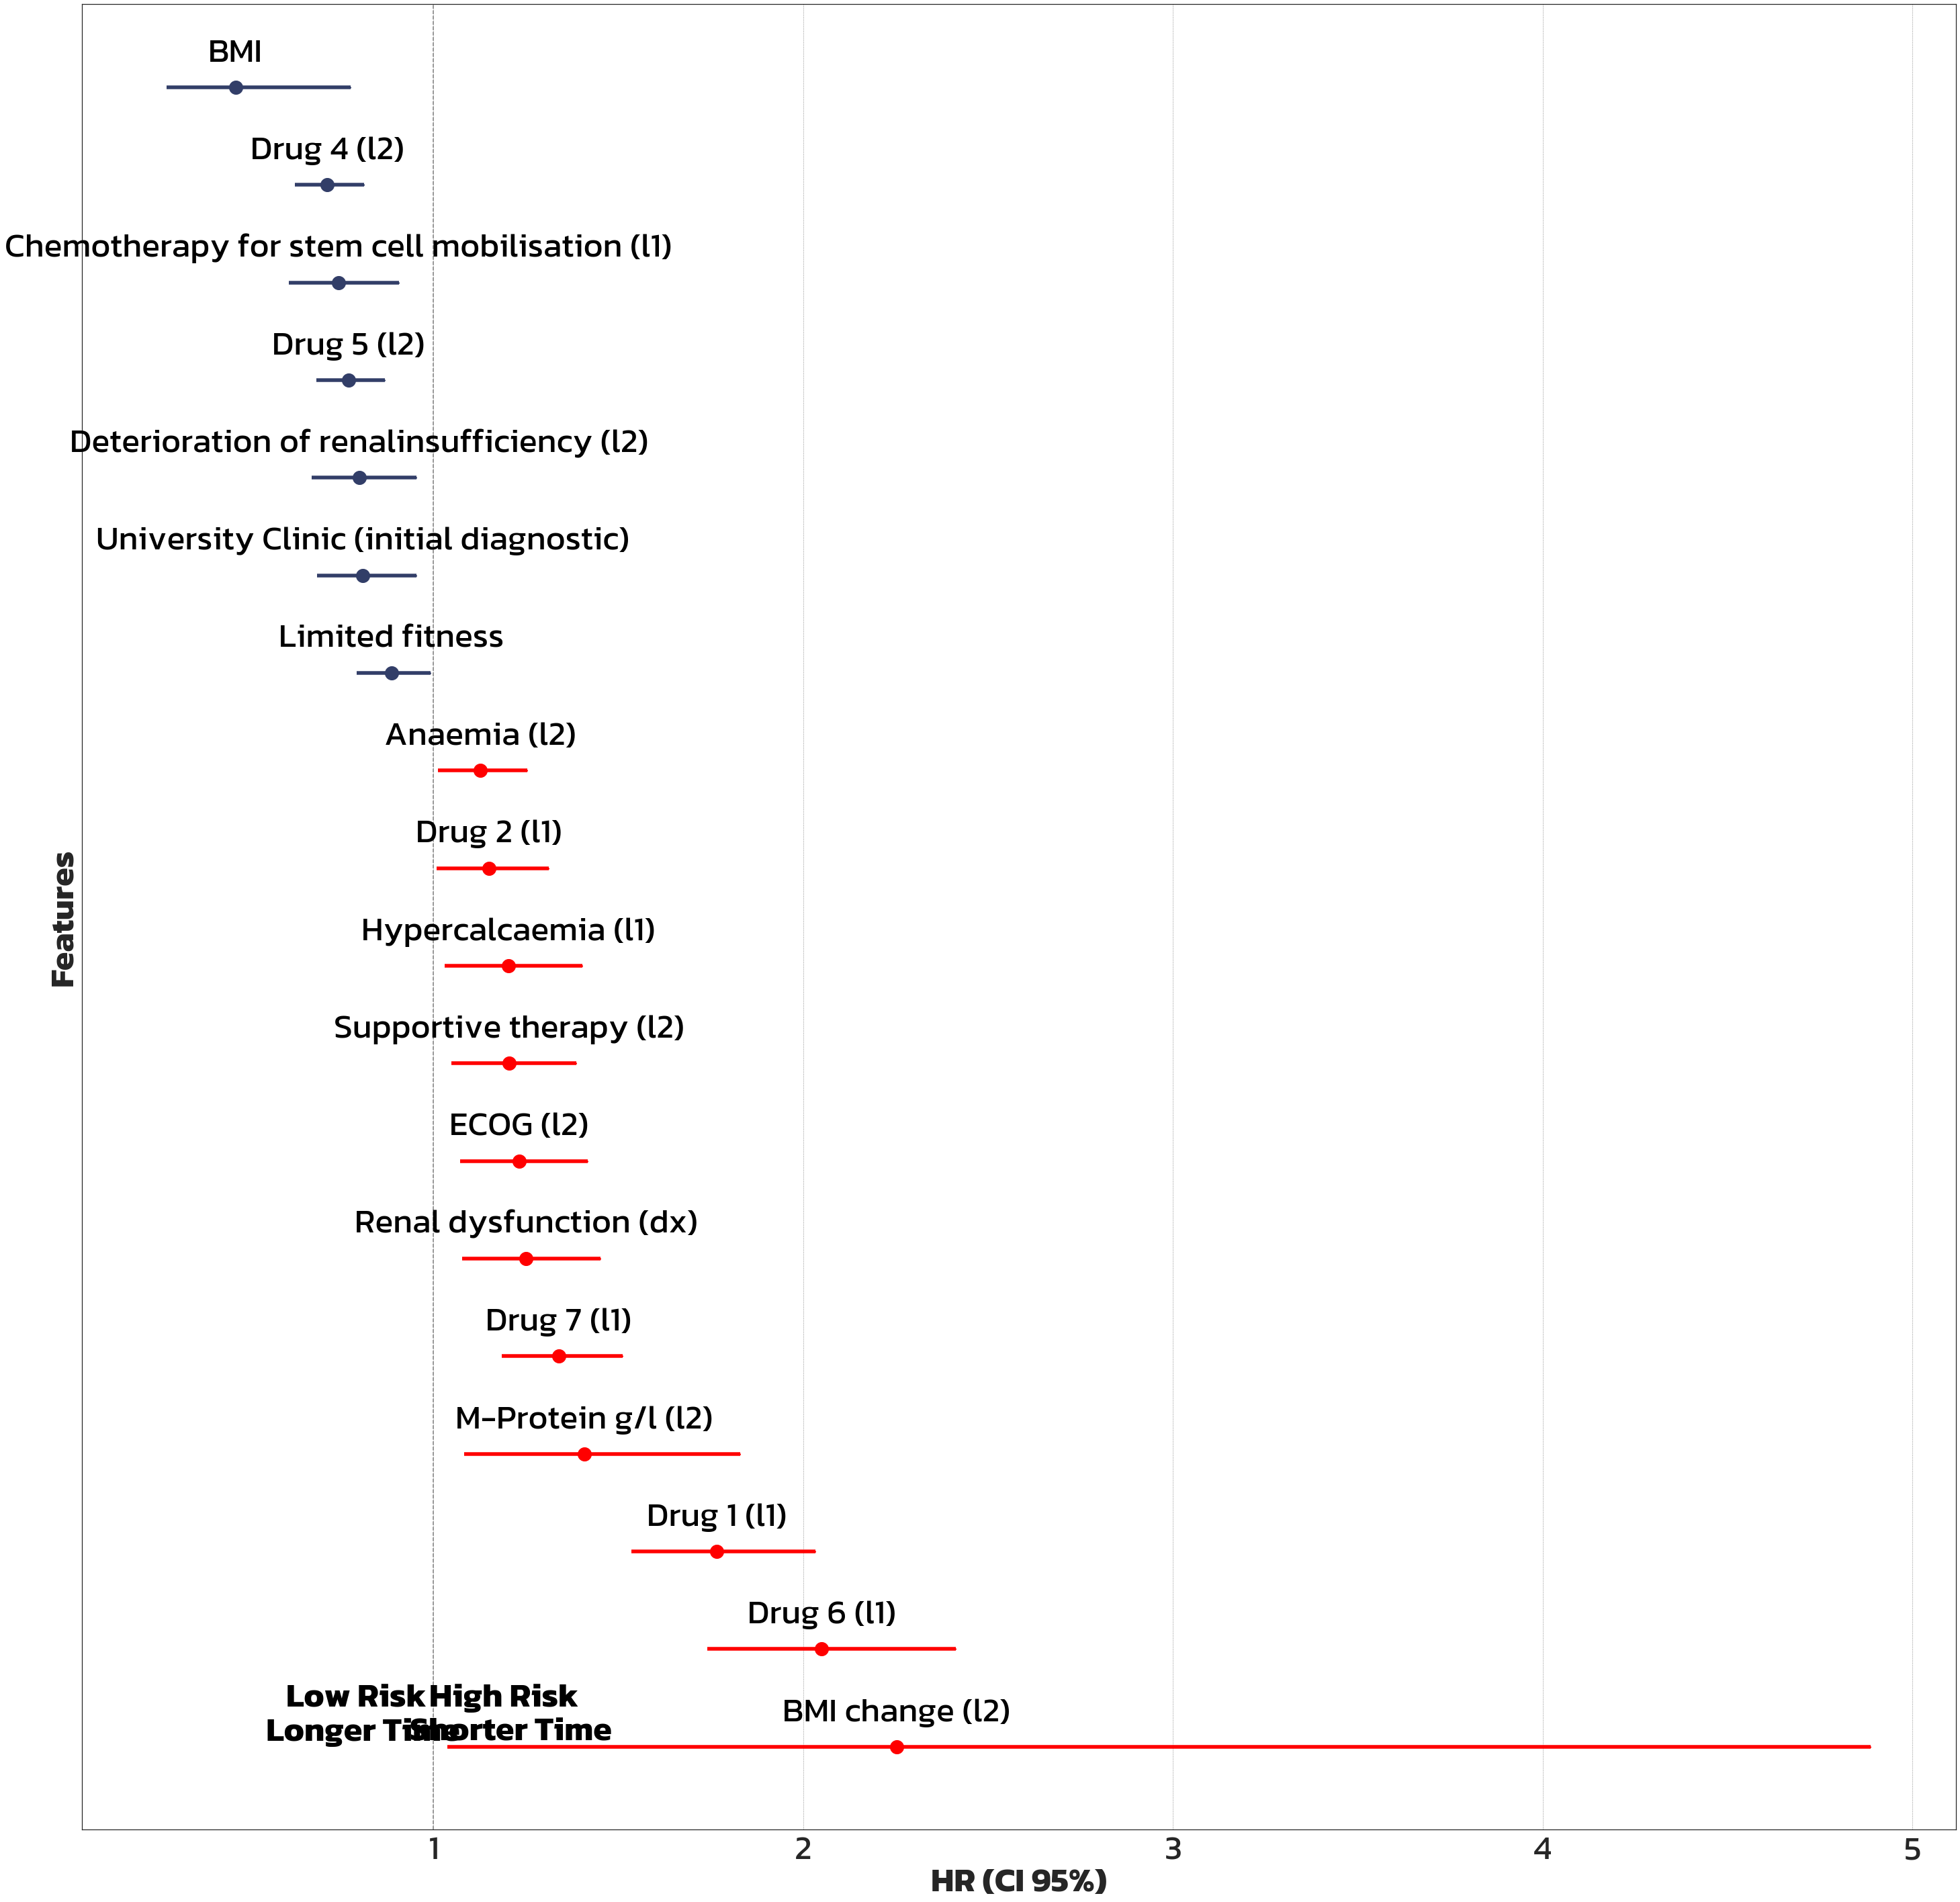

C-index with Lasso less significant features clean-up method:
train: not related test: 0.6097154691157932
C-index without Lasso less significant features clean-up method:
train: not related test: 0.6078532488581111
['test_df', 'test', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'MaxAbsScaler()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 'not related', 0.6097154691157932, 'not related', 0.6078532488581111]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_training_df exist
Directory ../intermediate_report/24-03-18_training_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat'

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/read_data.py:12: DtypeWarning: Columns (109,111,113,115,117,119,120,124,125,185,186,187,298,301,304) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx_protg', 'l1_protg', 'l2_protg', 'dx_lightrat', 'l1_lightrat', 'l2_lightrat', 'dx_lightkap', 'l1_lightkap', 'l2_lightkap', 'dx_lightlam', 'l1_lightlam', 'l2_lightlam', 'l1_supperythnr', 'l2_supperythnr', 'l1_TTNT', 'l2_TTNT']
dx_weight upper_outliers: 2       999.0
64      999.0
77      120.0
82      999.0
93      999.0
        ...  
2346    130.0
2478    999.0
2501    999.0
2520    118.0
2544    999.0
Name: dx_weight, Length: 79, dtype: float64
dx_weight lower_outliers: 582     9.0
726     9.0
1817    9.0
2464    9.0
Name: dx_weight, dtype: float64
l1_weight upper_outliers: 2       999.0
64      999.0
77      120.0
93      999.0
129     999.0
        ...  
2346    130.0
2433    999.0
2465    999.0
2478    999.0
2520    118.0
Name: l1_weight, Length: 78, dtype: float64
l1_weight lower_outliers: 230    9.0
582    9.0
726    9.0


/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

Wrong data in column l2_BMI:
Series([], Name: l2_BMI, dtype: float64)
 
Total number of rows with wrong data: 
(0, 393)
 
Wrong data: 
Empty DataFrame
Columns: [dx_weight, l1_weight, l2_weight, dx_height, l1_height, l2_height]
Index: []
 
BMI_change was added to the dataframe
Control output of used datatype: 
['dx_birthd', 'dx_iddat', 'l1_opdat', 'l2_opdat', 'l1_rtxstartdat', 'l2_rtxstartdat', 'l1_rtxendedat', 'l2_rtxendedat']
START: DDMMYY_type_correction 

1. calculate duration of rtx
2. calculate relative age when patient was diagnosed
dx_iddat_age column was added to dataframe
l1_opdat_age column was added to dataframe
l2_opdat_age column was added to dataframe
3. Drop data ddmmyy-type columns
END: DDMMYY_type_correction 



../intermediate_report/24-03-18_training_df/raw_unique_values_and_missing_count.csv was created
List_ordinary_values:
['dx_dusa', 'l1_dusa', 'dx_iss', 'l1_iss', 'l2_iss', 'dx_riss', 'l1_riss', 'l2_riss', 'dx_mikroserlevel', 'l1_mikroserlevel', 'l2_mikroserlevel

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  protective = top_features[top_features['exp(coef)']<1][top_features['exp(coef) upper 95%']<1]
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:120: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  detrimental = top_features[top_features['exp(coef)']>1][top_features['exp(coef) lower 95%']>1]


                  covariate                                  feature_name
0            bin__l1_drug_6                                   Drug 6 (l1)
1            bin__l1_drug_1                                   Drug 1 (l1)
2            bin__l1_drug_7                                   Drug 7 (l1)
3           bin__l2_ecogbin                                     ECOG (l2)
4         bin__dx_crabkritr                        Renal dysfunction (dx)
5         bin__l2_suppdurch                       Supportive therapy (l2)
6         bin__l1_crabkritc                           Hypercalcaemia (l1)
7            bin__l1_drug_2                                   Drug 2 (l1)
8             num__l2_protg                            M-Protein g/l (l2)
9        num__l2_BMI_change                               BMI change (l2)
10              num__dx_BMI                                           BMI
11       cat__dx_einrid_1.0        University Clinic (initial diagnostic)
12  bin__l2_rtpnotwnierenin      Deter

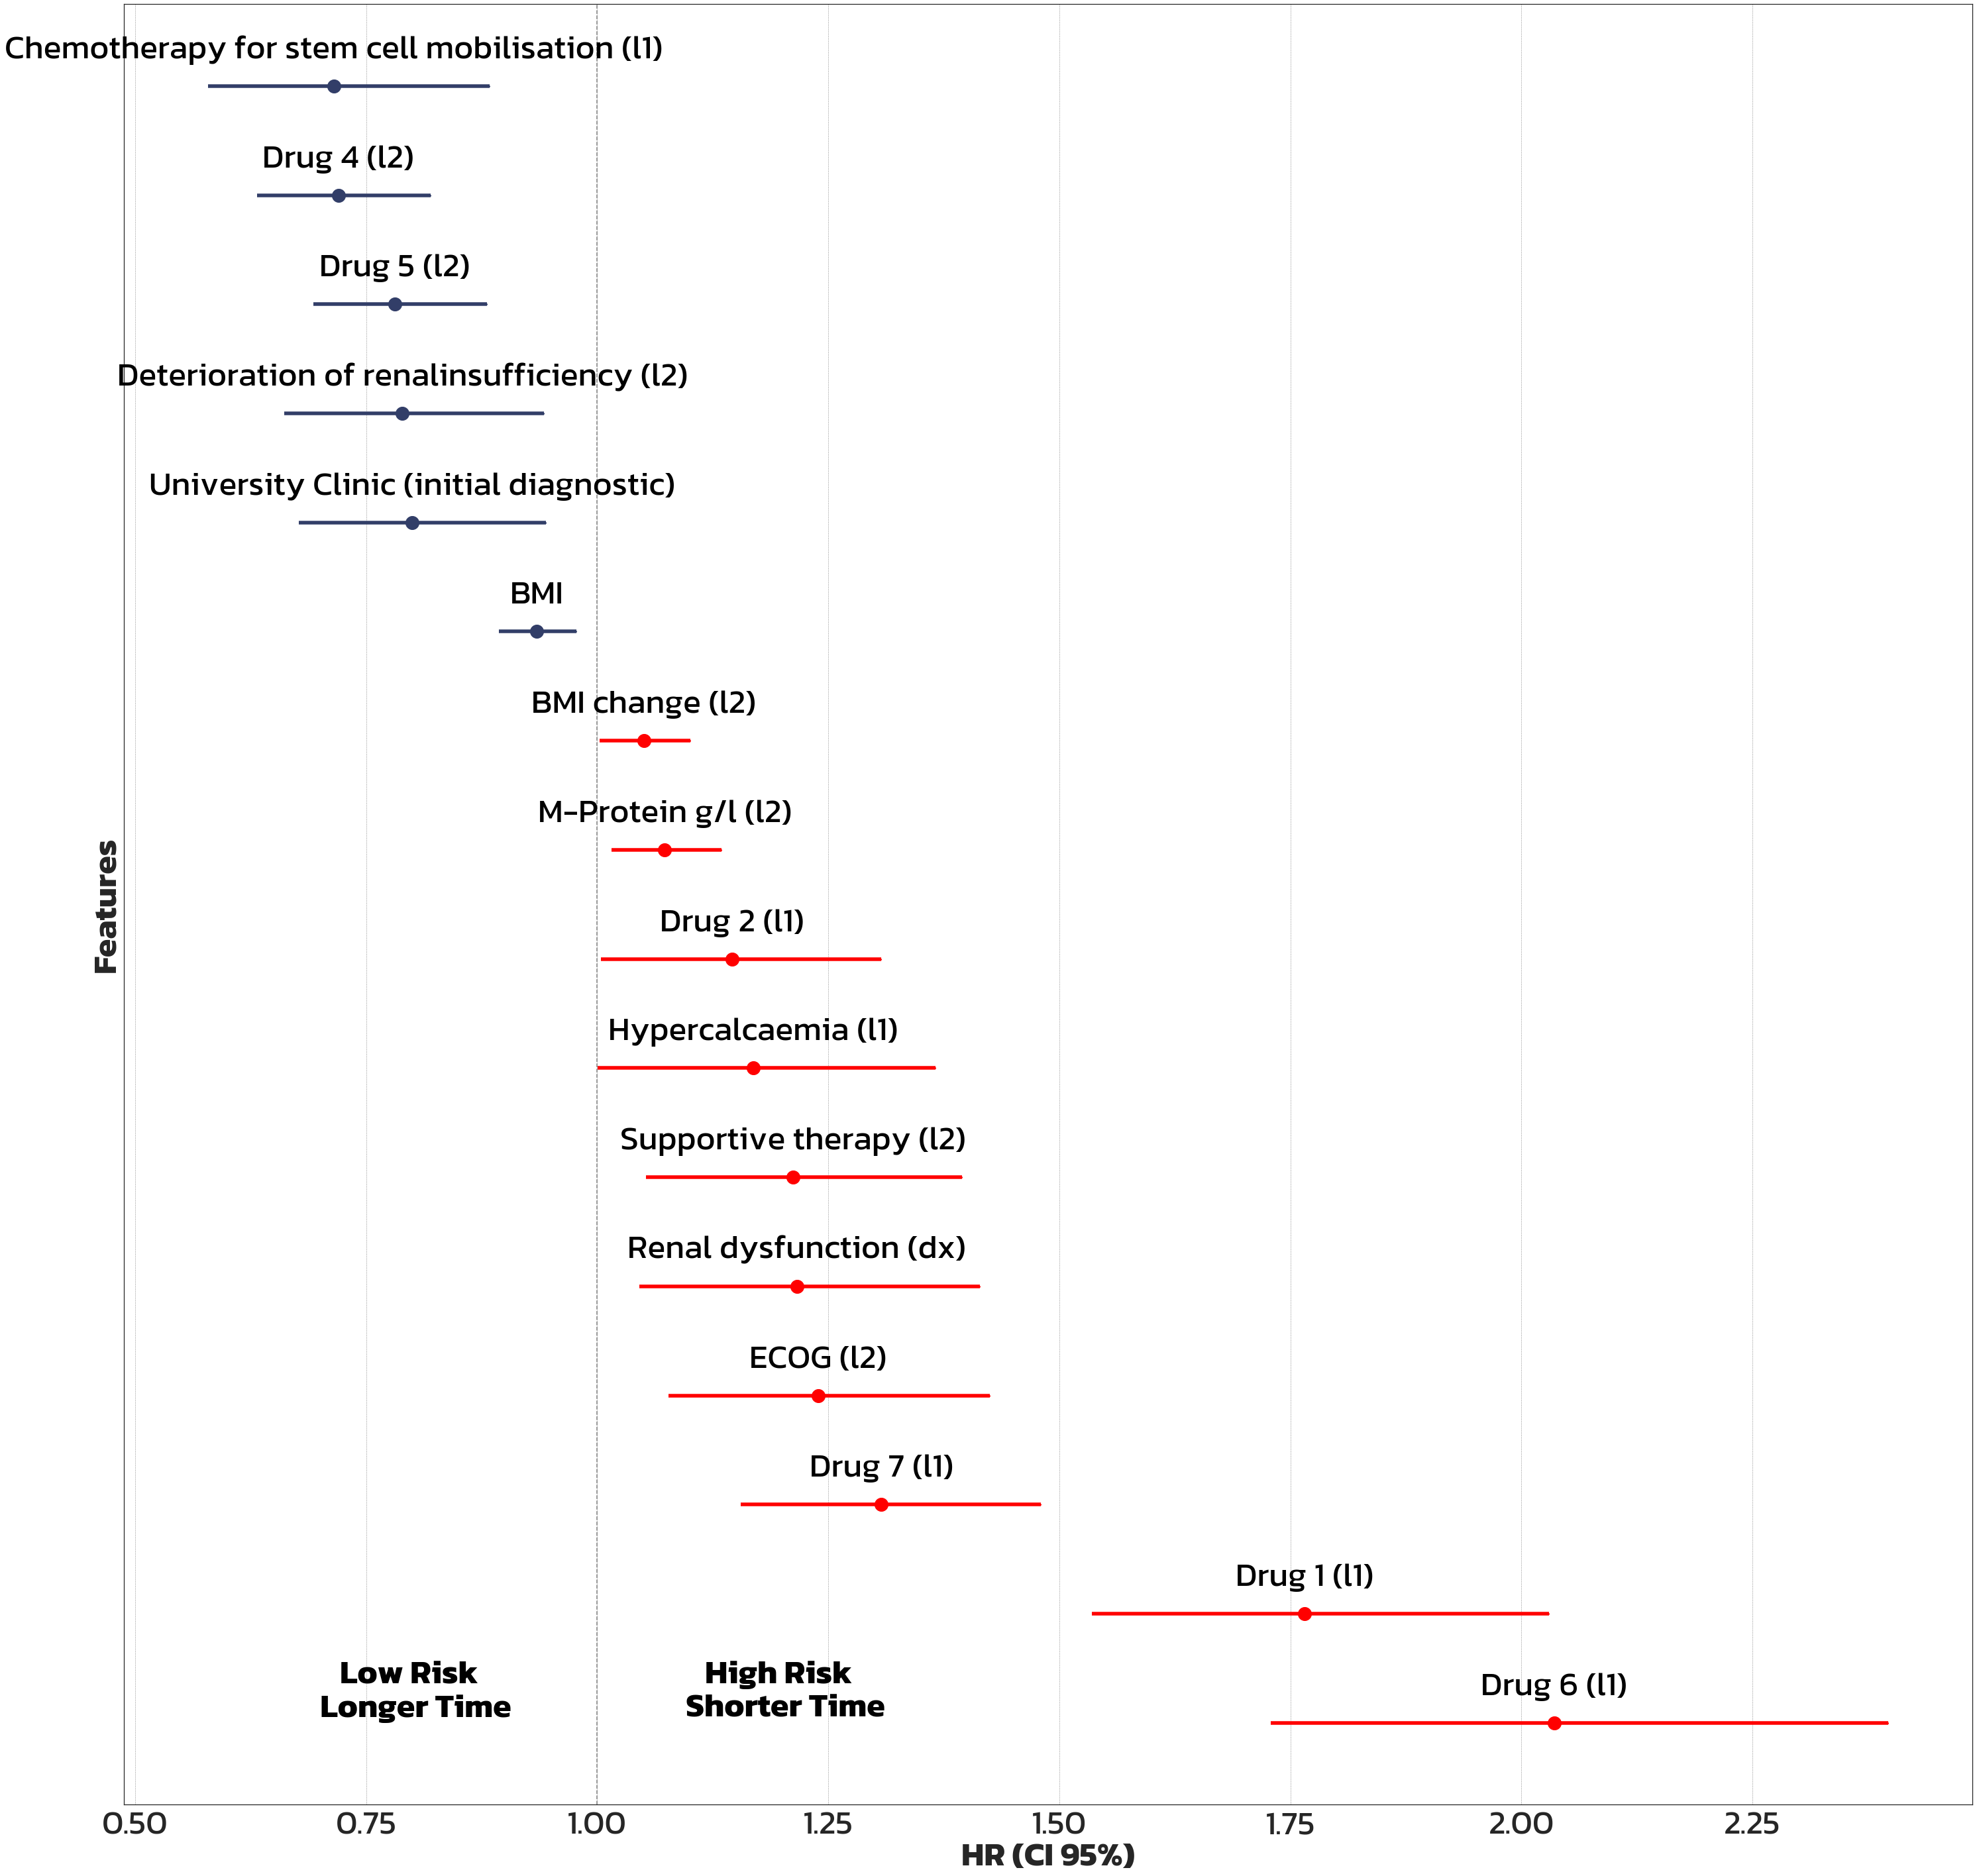

0.6147708122760907 0.610752847760751
C-index with Lasso less significant features clean-up method:
train: 0.6147708122760907 test: 0.610752847760751
C-index without Lasso less significant features clean-up method:
train: 0.6161905838341522 test: 0.612014396497347
['training_df', 'training', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'PowerTransformer()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 0.6147708122760907, 0.610752847760751, 0.6161905838341522, 0.612014396497347]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.
Directory ../intermediate_report exist
Directory ../intermediate_report/24-03-18_test_df exist
Directory ../intermediate_report/24-03-18_test_df/figures exist
Before convertion: 
Control output of used datatype: 
['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height', 'l2_height', 'dx_kofscore', 'l1_kofscore', 'l2_kofscore', 'dx

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03_mapping[list_item][df_03_mapping[list_item] > ref_number] = df_03_mapping[list_item] / 10
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/correction.py:223: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dropped_BMI = df_dropped_BMI.append(df_dropped_rows

 
Filled Data:
   dx_weight  l1_weight  l2_weight
0       44.0       44.0       50.0
1       76.0       76.0       76.0
2       68.0       68.0       68.0
3       63.0       63.0       60.0
4       79.0       79.0       77.0
Height Correction: 
 
Data with Nan:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Filled Data:
   dx_height  l1_height  l2_height
0      165.0      165.0      165.0
1      156.0      156.0      156.0
2      177.0      177.0      177.0
3      189.0      189.0      189.0
4      184.0      184.0      184.0
 
Check if data is in good range for height and weight: 
 
Height <110:
Empty DataFrame
Columns: [dx_weight, l1_weight, l2_weight, dx_height, l1_height, l2_height]
Index: []
 
Weight >140:
     dx_weight  l1_weight  l2_weight  dx_height  l1_height  l2_height
437      150.0      147.0      147.0      19

/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/feature_dropping.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/data_preprocess.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_load['event'] = 1
/Users/tatiana/Documents/courses/Bootcamp/TriNetX/Git_Project/trinetx/modules/cox_model.py:119:

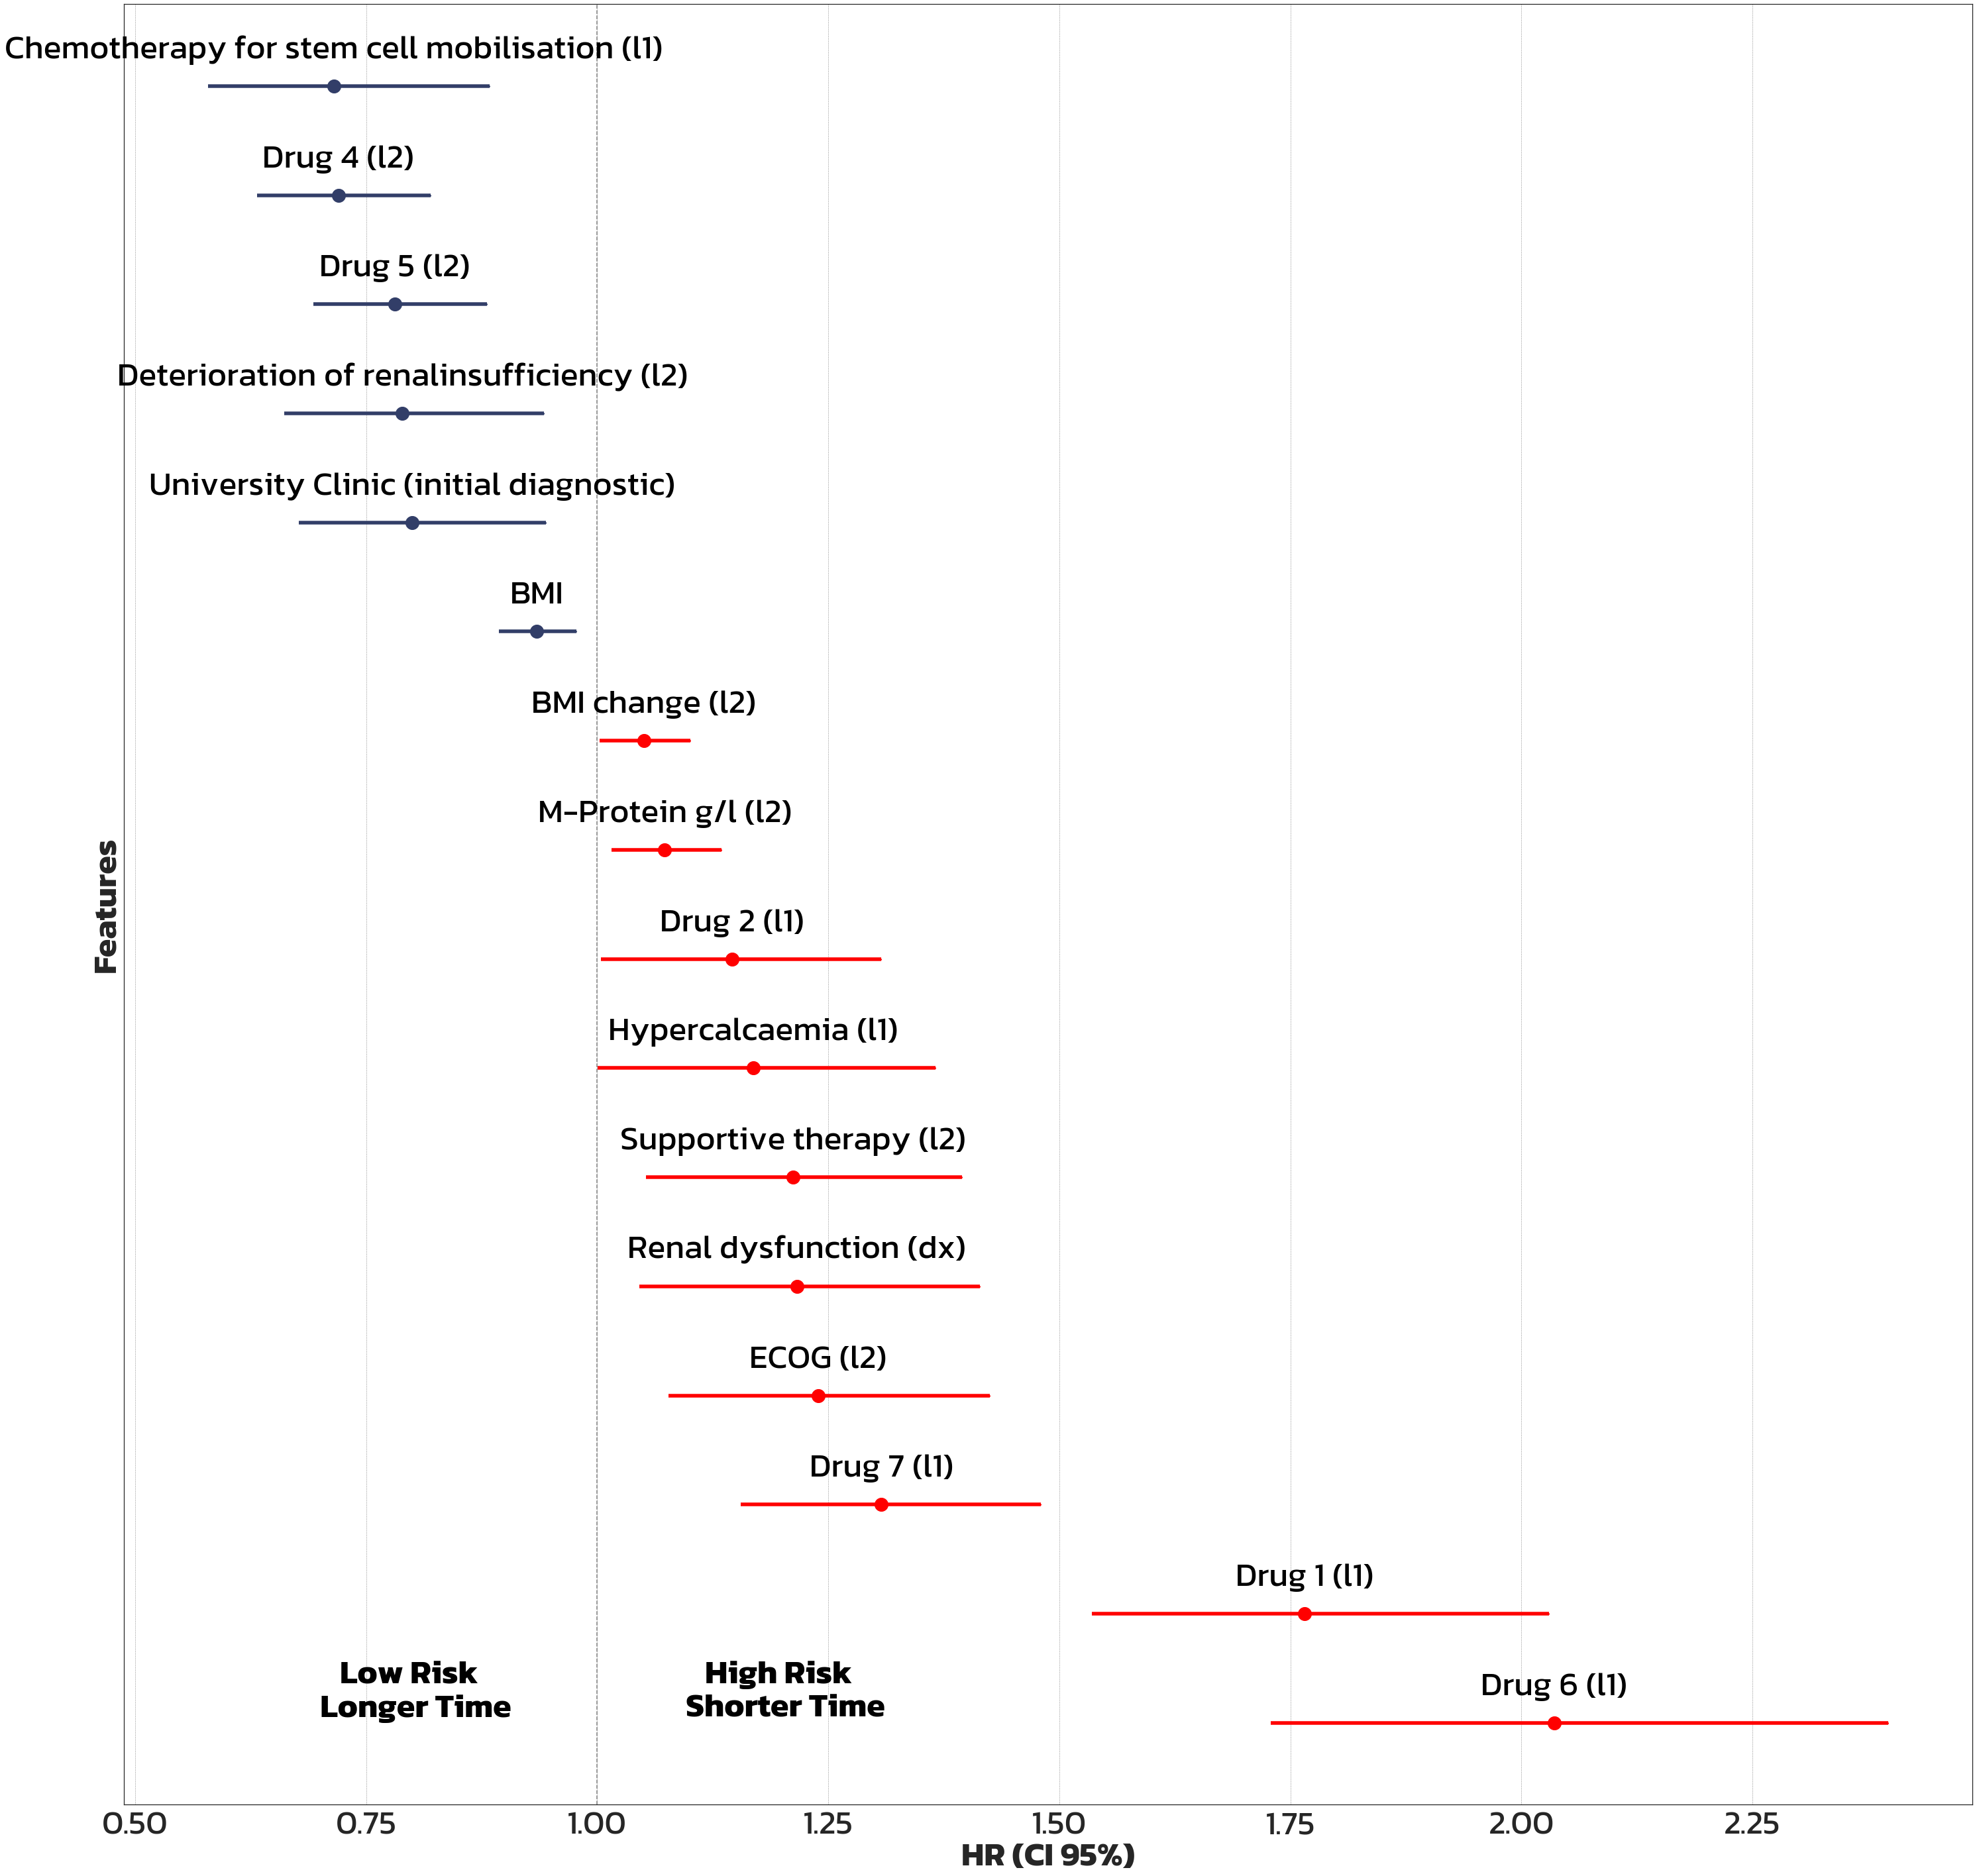

C-index with Lasso less significant features clean-up method:
train: not related test: 0.6108614508128285
C-index without Lasso less significant features clean-up method:
train: not related test: 0.6069487418758083
['test_df', 'test', "SimpleImputer(strategy='most_frequent')", 'KNNImputer(n_neighbors=10)', 'PowerTransformer()', 0.001, 0.9, '0.001_0.9_True_True_25', 'True_True_25', True, True, 25, 'not related', 0.6108614508128285, 'not related', 0.6069487418758083]
'../intermediate_report/../intermediate_report/24-03-18_imputer_choice/score_comparison_imputer_numeric.csv' already exists.


In [12]:
#Main loop of analysis
dictionary_imputer = {}
#loops for different data preprocessing parameters. 
#It can be just one value in each category, but to have more options and to automatize the process the loops were created. 
for combine_categories in combine_categories_list:
    for clean_feature in clean_feature_list:
        for threshold_feature_drop in threshold_feature_drop_list:
            for l1_ratio in l1_ratio_list:
                for penalizer in penalize_list:
                    #Loop for imputer types list:
                    for imputer_item in imputers_list:
                        imputer_key = str(imputer_item)
                        #specification of the imputer type 
                        if imputers_type =='cat':
                            cat_imputer = imputer_item
                        elif imputers_type =='num':
                            num_imputer = imputer_item
                        elif imputers_type =='scale':
                            scaler = imputer_item

                        if imputer_key not in dictionary_imputer:
                            dictionary_imputer[imputer_key] = {}
                        #preparing output dictionary to store C-index score value for each parameters
                        for data_name in data_name_list:
                            data_frame_type=data_name.split('_')[0]
                            if data_frame_type not in dictionary_imputer[imputer_key]:
                                dictionary_imputer[imputer_key][data_frame_type] = {'score_X_train': None, 'score_X_test': None}

                            #specify names, including model and imputer parameters to define the data output in result csv file
                            additional_name_model = f'{penalizer}_{l1_ratio}_{combine_categories}_{clean_feature}_{threshold_feature_drop}'
                            additional_name_imputer = f'{combine_categories}_{clean_feature}_{threshold_feature_drop}'
                            #data_frame_type = 'test'

                            #Steps of standart analysis from Analysis.ipynb
                            
                            # 1) Data preprocessing

                            df = read_df(data_name)
                            #def create_directory_main(data_name, parent_directory = "intermediate_report")
                            directory_name = create_directory_main(data_name, parent_directory = "intermediate_report")
                            df = data_correction(df,ecog_type=ecog_type)
                            df_missing_count(df,directory_name)
                            df_02_mapping, value_mapping = data_mapping(df, directory_name, data_name)
                            df_02_mapping.head()
                            value_mapping
                            #def drop_features(df,min_percent = 0.06, data_type ='train', combine_categories=True, data_name='', directory_name='', drop_list = ['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height','l2_height',	'l1_BMI'	,'l2_BMI', 'l1_klinstudie','l2_klinstudie','dx_mikrogl','l1_mikrogl','l2_mikrogl','dx_albugem','l1_albugem','l2_albugem','l1_protg']):
                            df_02_mapping_drop =  drop_features(df_02_mapping,min_percent = 0.06, data_type =data_frame_type, combine_categories=combine_categories, data_name=data_name, directory_name=directory_name, drop_list = ['dx_weight', 'l1_weight', 'l2_weight', 'dx_height', 'l1_height','l2_height',	'l1_BMI'	,'l2_BMI', 'l1_klinstudie','l2_klinstudie','dx_mikrogl','l1_mikrogl','l2_mikrogl','dx_albugem','l1_albugem','l2_albugem','l1_protg'])
                            
                            # RESULTS inside each loop: Feature importancy plot and C-index score

                            #specify the list of features, what should be excluded from plot of feature importancy:
                            #unvisible_list= ['bin__l2_rtpnotwnierenin','bin__l1_crabkritb','bin__dx_crabkritb','cat__l2_rtptheraentsch_3.0','cat__l2_prottyp_1.0','cat__l1_prottyp_2.0']
                            unvisible_list = []

                            # Preprocess data process with imputer from the imputer list
                            if data_frame_type=='training':
                                X_train, X_test = preprocess_data_choose_imputer(df_02_mapping_drop, threshold_feature_drop=threshold_feature_drop, additional_name=additional_name_imputer,cat_imputer=cat_imputer, num_imputer=num_imputer, scaler=scaler)

                            # Cox model feature importancy procedure
                            #def cox_feature_importancy(X_train, X_test, clean_feature = True ,data_type = 'training', feature_excluded_from_plot =[],size = (30,40), directory_name='',penalizer=0.0001, l1_ratio=0.9 ):

                                top_f_df, score_X_train, score_X_test, cph = cox_feature_importancy(X_train,X_test, clean_feature =True,data_type = data_frame_type, feature_excluded_from_plot =unvisible_list, size = (50,50), directory_name=directory_name, penalizer=penalizer, l1_ratio=l1_ratio, additional_name=additional_name_model)
                                print(score_X_train, score_X_test)

                            elif data_frame_type=='test':
                                df_test = preprocess_test_data(df_02_mapping_drop, additional_name=additional_name_imputer)
                                top_f_df, score_X_train, score_X_test, cph = cox_feature_importancy(_,df_test, clean_feature =True,data_type = data_frame_type,feature_excluded_from_plot =unvisible_list,size = (50,50), directory_name=directory_name, penalizer=penalizer, l1_ratio=l1_ratio,additional_name=additional_name_model)
                            

                            # Output the value of C-index score for train and test for each fix parameter combination inside the loop
                            print('C-index with Lasso less significant features clean-up method:')
                            print(f'train: {score_X_train} test: {score_X_test}')
                           
                            # Add C-index score data to the dictionary
                            dictionary_imputer[imputer_key][data_frame_type]['score_X_train'] = score_X_train
                            dictionary_imputer[imputer_key][data_frame_type]['score_X_test'] = score_X_test
                            
                            #This is different Cox model without  Lasso less significant features clean-up method. 
                            #Implementing it to the data you can find the difference of score improvement that gives Lasso less significant features clean-up method. 
                            if data_frame_type=='training':
                                score_X_train2,score_X_test2 = cox_model(X_train,X_test,data_type = data_frame_type, penalizer=penalizer, l1_ratio=l1_ratio)
                            elif data_frame_type=='test':
                                score_X_train2,score_X_test2 = cox_model(_,df_test,data_type = data_frame_type, penalizer=penalizer, l1_ratio=l1_ratio)

                            # C-index result of Different Cox model without Lasso less significant features clean-up method
                            print('C-index without Lasso less significant features clean-up method:')
                            print(f'train: {score_X_train2} test: {score_X_test2}')
                           

                            # Save all information about analysis parameters and models to the csv file: 
                            score_data = [data_name, data_frame_type, f'{cat_imputer}', f'{num_imputer}', f'{scaler}', penalizer, l1_ratio,  additional_name_model, additional_name_imputer, combine_categories, clean_feature, threshold_feature_drop, score_X_train, score_X_test, score_X_train2, score_X_test2]
                            print(score_data)
                           
                            filename = 'score_comparison_imputer_numeric.csv'
                            file_path = f'../intermediate_report/{imputer_choice_directory}/{filename}'
                            # Check if the file does not exist
                            
                            if not os.path.exists(file_path):
                                # File does not exist, create it
                                with open(file_path, 'w') as file:
                                    #file.write('data_name', 'data_frame_type', 'penalizer', 'l1_ratio',  'additional_name_model', 'additional_name_imputer', 'score_X_train FI', 'score_X_test FI', 'score_X_train2', 'score_X_test2')  # You can write headers or initial data if needed
                                    file.write('data_name, data_frame_type, cat_imputer, num_imputer, scaler, penalizer, l1_ratio,  additional_name_model, additional_name_imputer, combine_categories, clean_feature, threshold_feature_drop, score_X_train, score_X_test, score_X_train2, score_X_test2 \n')
                                print(f"'{file_path}' created.")
                            else:
                                print(f"'{file_path}' already exists.")
                            
                            with open(file_path, 'a', newline='') as file:
                                writer = csv.writer(file)

                                # Write new data
                                writer.writerow(score_data)

In [13]:
# Dictionary of C-index scores results for each type of imputer : dictionary_imputer
dictionary_imputer_cat= dictionary_imputer.copy()
dictionary_imputer_cat

{'StandardScaler()': {'training': {'score_X_train': 0.6127421370596045,
   'score_X_test': 0.6099884976438722},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6097154691157932}},
 'MinMaxScaler()': {'training': {'score_X_train': 0.6127421370596045,
   'score_X_test': 0.6099884976438722},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6097154691157932}},
 'RobustScaler()': {'training': {'score_X_train': 0.6127421370596045,
   'score_X_test': 0.6099884976438722},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6097154691157932}},
 'QuantileTransformer()': {'training': {'score_X_train': 0.6146045160316065,
   'score_X_test': 0.6135727802307892},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6120115253016387}},
 'Normalizer()': {'training': {'score_X_train': 0.6148764266040639,
   'score_X_test': 0.6115839857519202},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6058723376389503}},
 'MaxAbsScaler()': {'tr

In [14]:
dictionary_imputer

{'StandardScaler()': {'training': {'score_X_train': 0.6127421370596045,
   'score_X_test': 0.6099884976438722},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6097154691157932}},
 'MinMaxScaler()': {'training': {'score_X_train': 0.6127421370596045,
   'score_X_test': 0.6099884976438722},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6097154691157932}},
 'RobustScaler()': {'training': {'score_X_train': 0.6127421370596045,
   'score_X_test': 0.6099884976438722},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6097154691157932}},
 'QuantileTransformer()': {'training': {'score_X_train': 0.6146045160316065,
   'score_X_test': 0.6135727802307892},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6120115253016387}},
 'Normalizer()': {'training': {'score_X_train': 0.6148764266040639,
   'score_X_test': 0.6115839857519202},
  'test': {'score_X_train': 'not related',
   'score_X_test': 0.6058723376389503}},
 'MaxAbsScaler()': {'tr

In [15]:
imputer_choice_directory

'../intermediate_report/24-03-18_imputer_choice'

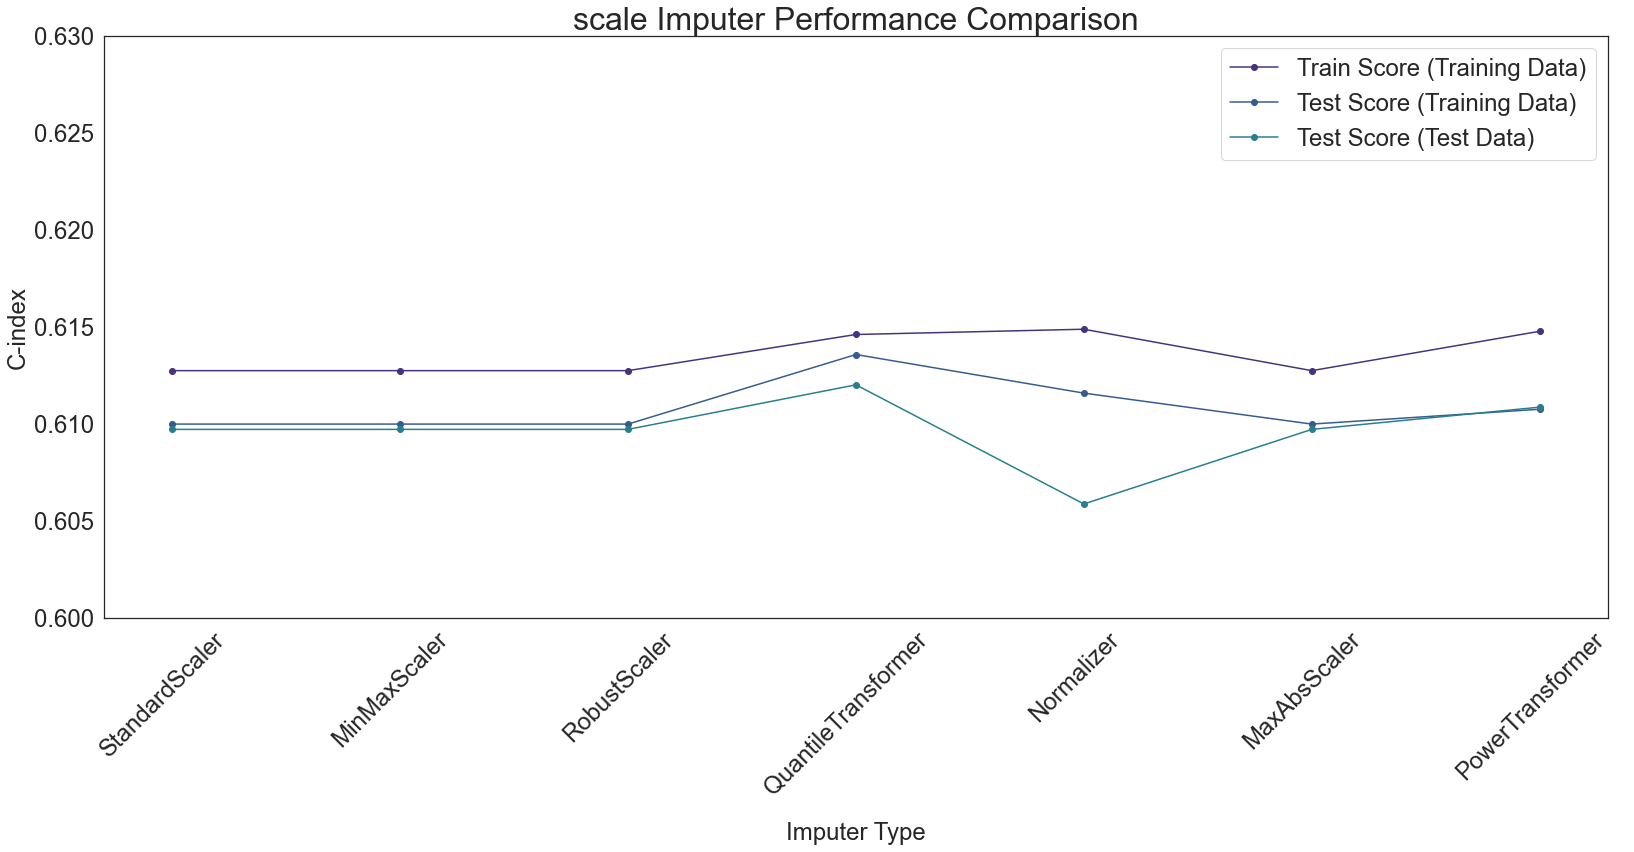

In [16]:
Ylim_1 = 0.6
Ylim_2 = 0.63
fontsize=24

plot_imputer_performance_comparison(Ylim_1, Ylim_2, fontsize, dictionary_imputer, additional_name_plot,imputers_type,imputer_choice_directory)
